In [ ]:
## Developing the model ###

# Load Libraries
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Import data
kickstarter_df = pd.read_excel("Kickstarter.xlsx")

# Pre-Processing

Keeping Only 'successful' and 'failed' states

In [ ]:
kickstarter_df = kickstarter_df.dropna()

# Looking at different values of "state"
kickstarter_df['state'].value_counts()

# Keeping the rows where state is successful or failed else drop
kickstarter_df = kickstarter_df[kickstarter_df['state'].isin(['successful', 'failed'])]

kickstarter_df['state'] = kickstarter_df['state'].apply(lambda x: 1 if x=='successful' else 0)

In [ ]:
kickstarter_df.shape

(14185, 47)

Dropping forward looking predictors

In [ ]:
kickstarter_df = kickstarter_df.drop(columns=['backers_count','pledged','state_changed_at_month','state_changed_at_day', 'state_changed_at_yr', 'state_changed_at_hr','state_changed_at_weekday'], errors='ignore')


# EDA

Checking the distribution of goal wrt state

In [ ]:
# View the distribution of 'goal' values for each state
kickstarter_df.groupby('state')['goal'].describe()

,count,mean,std,min,25%,50%,75%,max
state,,,,,,,,
0,6098.0,122287.050016,2.091439e+06,1.0,3000.0,10000.0,28631.25,100000000.0
1,8087.0,30940.428713,1.133594e+06,1.0,1000.0,4000.0,10000.00,100000000.0


Checking distribution of 'disable_communication'

In [ ]:
# Checking distribution of "disable_communication"
kickstarter_df['disable_communication'].value_counts()

,count
disable_communication,
False,14185


Since the column "disable_communication" has only one unique value, this is not informative about the final state and hence can be dropped.

In [ ]:
# Dropping column "disable_communication"
kickstarter_df = kickstarter_df.drop(['disable_communication'], axis=1)

Checking distribution of 'country'

In [ ]:
print("Number of countries:",kickstarter_df['country'].value_counts().shape[0])
kickstarter_df['country'].value_counts().head(10)

Number of countries: 114


,count
country,
US,8289
GB,1749
CA,687
MX,448
DE,345
AU,329
FR,311
IT,279
ES,268


Checking distribution of 'currency'

In [ ]:
# Checking value counts of currency
kickstarter_df['currency'].value_counts()

,count
currency,
USD,8490
GBP,1797
EUR,1660
CAD,720
MXN,442
AUD,342
HKD,167
SEK,115
JPY,107


Checking countrywise distribution of state

In [ ]:
# View the distribution of 'state' values for each country
kickstarter_df.groupby('country')['state'].value_counts().head(10)

country  state
AE       0         2
         1         1
AF       1         2
AM       0         1
         1         1
AO       1         1
AR       0         3
         1         2
AT       0        25
         1        25
Name: count, dtype: int64

Checking distribution of Project Deadlines per year

In [ ]:
# Minimum deadline
min_deadline = kickstarter_df['deadline'].min()
print(f"Minimum Deadline: {min_deadline}")

# Maximum deadline
max_deadline = kickstarter_df['deadline'].max()
print(f"Maximum Deadline: {max_deadline}")

# Example: Count the number of projects with deadlines in each year
kickstarter_df['deadline_year'] = kickstarter_df['deadline'].dt.year
deadline_distribution = kickstarter_df['deadline_year'].value_counts().sort_index()
print("\nDistribution of Deadlines by Year:")
deadline_distribution

Minimum Deadline: 2017-01-05 17:13:20
Maximum Deadline: 2024-06-15 20:00:00

Distribution of Deadlines by Year:


,count
deadline_year,
2017,2721
2018,2307
2019,2025
2020,1947
2021,2077
2022,2464
2023,589
2024,55


Checking distribution of states of project by deadlines

In [ ]:
# Group by 'deadline_year' and 'state', then count the occurrences
state_by_year = kickstarter_df.groupby(['deadline_year', 'state'])['state'].count().unstack()

# Display the distribution
print("\nDistribution of State by Year:")
state_by_year


Distribution of State by Year:


state,0,1
deadline_year,,
2017,1418,1303
2018,1168,1139
2019,972,1053
2020,801,1146
2021,767,1310
2022,814,1650
2023,152,437
2024,6,49


Confirming whether **state_changed_at** represents the decision date, which occurs after the project deadline.

In [ ]:
# Calculate the difference between 'state_changed_at' and 'deadline' in days
kickstarter_df['deadline'] = pd.to_datetime(kickstarter_df['deadline'])
kickstarter_df['state_changed_at'] = pd.to_datetime(kickstarter_df['state_changed_at'])

kickstarter_df['time_diff'] = (kickstarter_df['state_changed_at'] - kickstarter_df['deadline']).dt.days

# Display the value counts of the difference
print(kickstarter_df['time_diff'].value_counts())

time_diff
0     14184
22        1
Name: count, dtype: int64


We will assume that the **state changed date** represents the **decision date**, which indicates when the outcome of the project—whether it was successful or not—was determined. (Since the state changed date is same as deadline.)

In [ ]:
kickstarter_df = kickstarter_df.drop(columns=['state_changed_at','time_diff'], errors='ignore')


Distribution of Number of projects by year

In [ ]:
project_counts_by_year = kickstarter_df.groupby(kickstarter_df['created_at'].dt.year)['created_at'].count()
print("\nNumber of projects by year (based on created_at):")
print(project_counts_by_year)


Number of projects by year (based on created_at):
created_at
2011       1
2012      11
2013      23
2014      15
2015      48
2016     289
2017    2824
2018    2207
2019    2061
2020    2026
2021    2070
2022    2610
Name: created_at, dtype: int64


Checking the distribution of the column "created_at" wrt state (Date when the project was created)

In [ ]:
# Group by 'created_at' and 'state', then count the occurrences
created_state_counts = kickstarter_df.groupby([kickstarter_df['created_at'].dt.year, 'state'])['state'].count().unstack()

# Display the distribution
print("\nDistribution of State by Created Year:")
created_state_counts


Distribution of State by Created Year:


state,0,1
created_at,,
2011,NaN,1.0
2012,3.0,8.0
2013,7.0,16.0
2014,8.0,7.0
2015,28.0,20.0
2016,139.0,150.0
2017,1488.0,1336.0
2018,1098.0,1109.0
2019,982.0,1079.0


Checking the distribution of the column "launched_at"  (Date when the project was launched)

In [ ]:
# Number of projects by year
project_counts_by_year = kickstarter_df.groupby(kickstarter_df['launched_at'].dt.year)['launched_at'].count()
print("\nNumber of projects by year (based on launched_at):")
print(project_counts_by_year)


Number of projects by year (based on launched_at):
launched_at
2017    2903
2018    2264
2019    2039
2020    1946
2021    2058
2022    2500
2023     426
2024      49
Name: launched_at, dtype: int64


Checking the distribution of the column "launched_at"  (Date when the project was launched)

In [ ]:
# Group by 'created_at' and 'state', then count the occurrences
created_state_counts = kickstarter_df.groupby([kickstarter_df['launched_at'].dt.year, 'state'])['state'].count().unstack()

# Display the distribution
print("\nDistribution of State by Created Year:")
created_state_counts


Distribution of State by Created Year:


state,0,1
launched_at,,
2017,1524,1379
2018,1134,1130
2019,989,1050
2020,783,1163
2021,779,1279
2022,797,1703
2023,87,339
2024,5,44


Checking how long did it take for project to get created and launched

In [ ]:
# Calculate the difference between 'launched_at' and 'created_at' in months
kickstarter_df['launched_at'] = pd.to_datetime(kickstarter_df['launched_at'])
kickstarter_df['created_at'] = pd.to_datetime(kickstarter_df['created_at'])
kickstarter_df['months_diff_bw_create_launch'] = (kickstarter_df['launched_at'] - kickstarter_df['created_at']).dt.days / 30

# Create month difference buckets
bins = [0, 1, 3, 6, 12, float('inf')]
labels = ['0-1 Month', '1-3 Months', '3-6 Months', '6-12 Months', '12+ Months']
kickstarter_df['months_diff_buckets'] = pd.cut(kickstarter_df['months_diff_bw_create_launch'], bins=bins, labels=labels, right=False)

# Display value counts without ordering
kickstarter_df['months_diff_buckets'].value_counts(sort=False)

,count
months_diff_buckets,
0-1 Month,9542
1-3 Months,2652
3-6 Months,897
6-12 Months,555
12+ Months,539


Checking the state distribution wrt the project completion time

In [ ]:
# Group by 'months_diff_buckets' and 'country', then count the occurrences of each state
state_by_month_country = kickstarter_df.groupby(['months_diff_buckets'])['state'].value_counts().unstack()

# Display the distribution
print("\nDistribution of State by Month Difference Buckets and Country:")
state_by_month_country


Distribution of State by Month Difference Buckets and Country:


<ipython-input-23-15096d0ac7c5>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  state_by_month_country = kickstarter_df.groupby(['months_diff_buckets'])['state'].value_counts().unstack()


state,0,1
months_diff_buckets,,
0-1 Month,4508,5034
1-3 Months,877,1775
3-6 Months,298,599
6-12 Months,213,342
12+ Months,202,337


In [ ]:
# Calculate the difference between 'launched_at' and 'created_at' in months
kickstarter_df['launched_at'] = pd.to_datetime(kickstarter_df['launched_at'])
kickstarter_df['deadline'] = pd.to_datetime(kickstarter_df['deadline'])
kickstarter_df['months_diff_bw_launch_deadline'] = (kickstarter_df['launched_at'] - kickstarter_df['deadline']).dt.days / 30

In [ ]:
# Check if 'spotlight' column exists in your DataFrame
if 'spotlight' in kickstarter_df.columns:
    unsuccessful_spotlight_projects = kickstarter_df[(kickstarter_df['state'] == 0) & (kickstarter_df['spotlight'] == 1)]
    if not unsuccessful_spotlight_projects.empty:
        print("Unsuccessful projects in spotlight:")
        print(unsuccessful_spotlight_projects)
    else:
        print("No unsuccessful projects found in the spotlight.")
else:
    print("The column 'spotlight' does not exist in the DataFrame.")

No unsuccessful projects found in the spotlight.


"Spotlight" is a forward looking column, hence needs to be dropped.

In [ ]:
# Dropping column "spotlight"
kickstarter_df = kickstarter_df.drop(['spotlight'], axis=1)

In [ ]:
# from textblob import TextBlob
# kickstarter_df['name_sentiment'] = kickstarter_df['name'].apply(lambda x: TextBlob(x).sentiment.polarity)

Checking the distribution of the length of project name wrt state

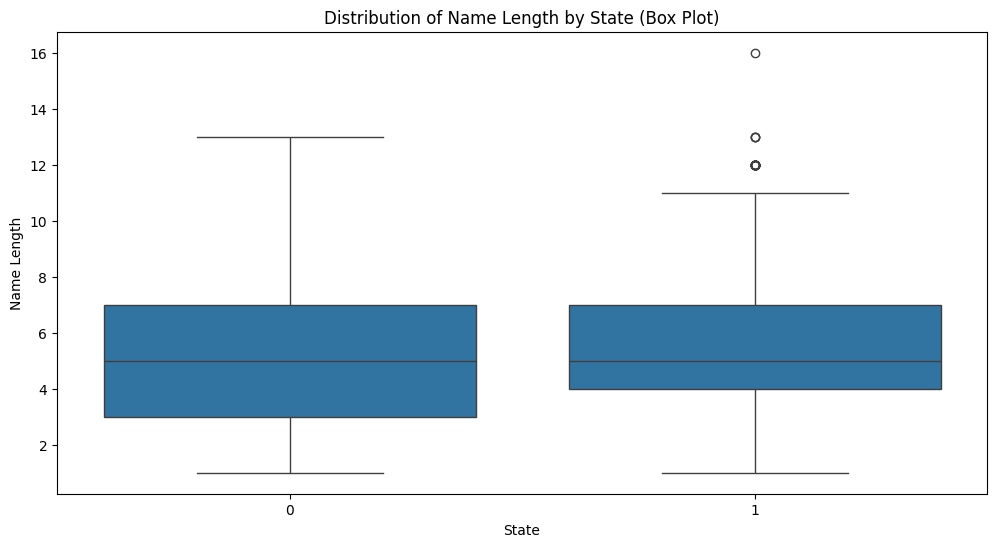

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Alternative way to visualize: Box plots
plt.figure(figsize=(12, 6))
sns.boxplot(x='state', y='name_len', data=kickstarter_df)
plt.title('Distribution of Name Length by State (Box Plot)')
plt.xlabel('State')
plt.ylabel('Name Length')
plt.show()

The distribution of length of the projetc name is very similar for 'successful' and 'failed' projects.

Checking the distribution of the length of clean project name wrt state

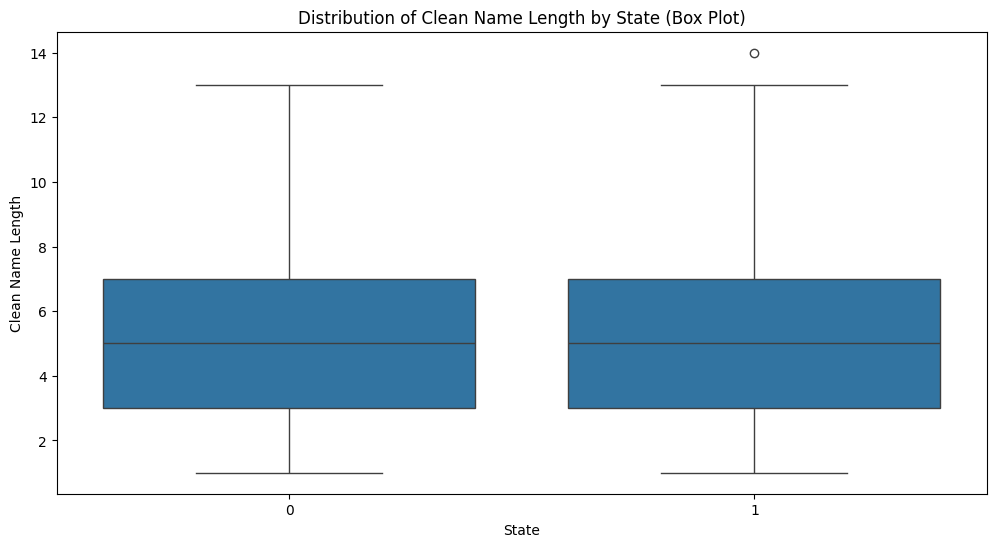

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Alternative way to visualize: Box plots
plt.figure(figsize=(12, 6))
sns.boxplot(x='state', y='name_len_clean', data=kickstarter_df)
plt.title('Distribution of Clean Name Length by State (Box Plot)')
plt.xlabel('State')
plt.ylabel('Clean Name Length')
plt.show()

The distribution of length of the clean project name is mostly same for 'successful' and 'failed' projects. Hence, it will not be a useful predictor.

Checking the distribution of the length of blurb name wrt state

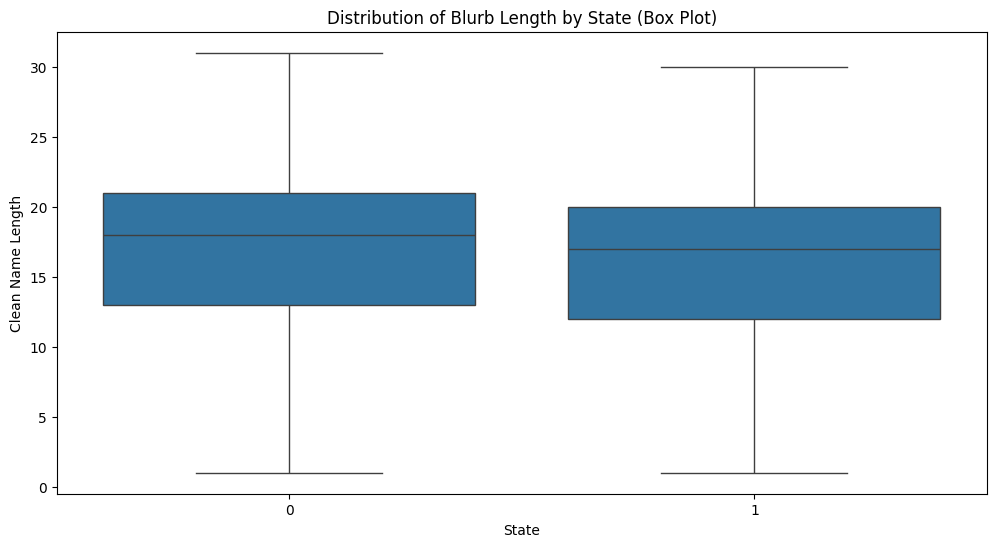

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Alternative way to visualize: Box plots
plt.figure(figsize=(12, 6))
sns.boxplot(x='state', y='blurb_len', data=kickstarter_df)
plt.title('Distribution of Blurb Length by State (Box Plot)')
plt.xlabel('State')
plt.ylabel('Clean Name Length')
plt.show()

The median length of blurb name of 'failed' projects is a bit higher than that of 'successful' projects.

Checking the distribution of the length of clean blurb name wrt state

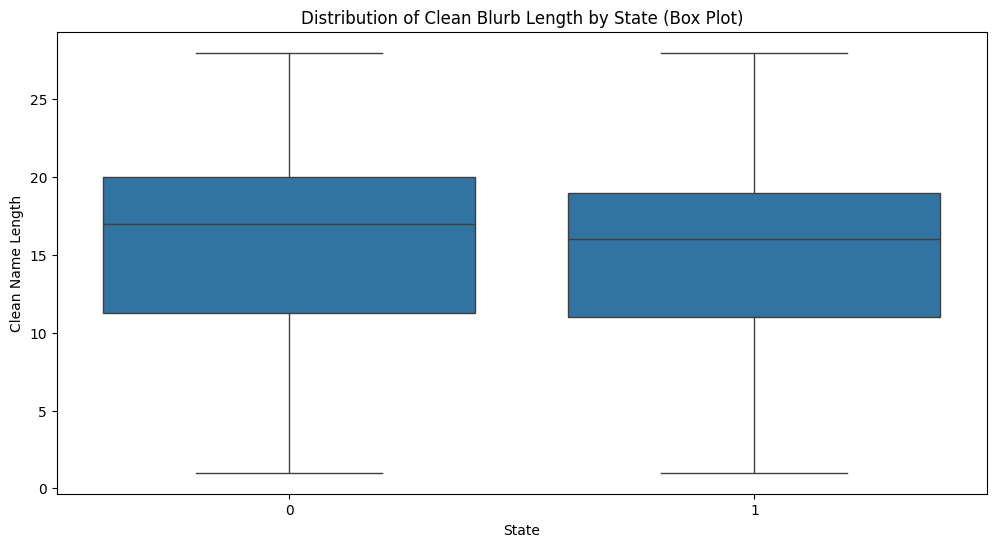

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Alternative way to visualize: Box plots
plt.figure(figsize=(12, 6))
sns.boxplot(x='state', y='blurb_len_clean', data=kickstarter_df)
plt.title('Distribution of Clean Blurb Length by State (Box Plot)')
plt.xlabel('State')
plt.ylabel('Clean Name Length')
plt.show()

The median length of clean blurb name of 'failed' projects is a bit higher than that of 'successful' projects.

Checking the distribution of 'successful' and 'failed' projects by weekday of deadline.

In [ ]:
# Group by deadline weekday and state, then calculate the percentage
weekday_state_percentage = kickstarter_df.groupby('deadline_weekday')['state'].value_counts(normalize=True) * 100

# Display the percentage distribution
weekday_state_percentage

deadline_weekday  state
Friday            1        57.866902
                  0        42.133098
Monday            1        53.885135
                  0        46.114865
Saturday          1        56.717850
                  0        43.282150
Sunday            1        54.522739
                  0        45.477261
Thursday          1        60.943168
                  0        39.056832
Tuesday           1        55.680400
                  0        44.319600
Wednesday         1        57.809331
                  0        42.190669
Name: proportion, dtype: float64

The distribution shows that projects having deadline on Thursday had higher successful rates in the past.

Checking distribution of states of project by weekday of the created date

In [ ]:
# Group by deadline weekday and state, then calculate the percentage
weekday_state_percentage = kickstarter_df.groupby('created_at_weekday')['state'].value_counts(normalize=True) * 100

# Display the percentage distribution
weekday_state_percentage

created_at_weekday  state
Friday              1        58.504767
                    0        41.495233
Monday              1        58.061821
                    0        41.938179
Saturday            1        54.763537
                    0        45.236463
Sunday              1        53.841188
                    0        46.158812
Thursday            1        56.832579
                    0        43.167421
Tuesday             1        57.356077
                    0        42.643923
Wednesday           1        58.031320
                    0        41.968680
Name: proportion, dtype: float64

The distribution shows that projects created on Saturday had lower successful rates in the past.

Checking distribution of states of project by weekday of the launched date

In [ ]:
# Group by deadline weekday and state, then calculate the percentage
weekday_state_percentage = kickstarter_df.groupby('launched_at_weekday')['state'].value_counts(normalize=True) * 100

# Display the percentage distribution
weekday_state_percentage

launched_at_weekday  state
Friday               1        56.605548
                     0        43.394452
Monday               1        56.478691
                     0        43.521309
Saturday             1        53.194888
                     0        46.805112
Sunday               1        52.780396
                     0        47.219604
Thursday             1        55.998126
                     0        44.001874
Tuesday              1        61.493506
                     0        38.506494
Wednesday            1        56.884058
                     0        43.115942
Name: proportion, dtype: float64

The distribution shows that projects created on Tuesday had higher successful rates in the past.

Checking distribution of states of project by deadline month

In [ ]:
# Group by deadline weekday and state, then calculate the percentage
weekday_state_percentage = kickstarter_df.groupby('deadline_month')['state'].value_counts(normalize=True) * 100

# Display the percentage distribution
weekday_state_percentage

deadline_month  state
1               1        53.680634
                0        46.319366
2               1        58.502773
                0        41.497227
3               1        58.025622
                0        41.974378
4               1        60.866261
                0        39.133739
5               1        57.352941
                0        42.647059
6               1        56.459732
                0        43.540268
7               1        55.110733
                0        44.889267
8               1        53.899480
                0        46.100520
9               1        54.536862
                0        45.463138
10              1        58.373206
                0        41.626794
11              1        60.530421
                0        39.469579
12              1        54.739539
                0        45.260461
Name: proportion, dtype: float64

The distribution shows that projects havind deadline in months like Jan, Aug, Dec had lower successful rates in the past.

Checking distribution of states of project by deadline day

In [ ]:
# Group by deadline weekday and state, then calculate the percentage
weekday_state_percentage = kickstarter_df.groupby('deadline_day')['state'].value_counts(normalize=True) * 100

# Display the percentage distribution
weekday_state_percentage

deadline_day  state
1             1        59.263521
              0        40.736479
2             1        59.215686
              0        40.784314
3             1        58.558559
              0        41.441441
4             1        55.726872
              0        44.273128
5             1        56.719818
              0        43.280182
6             1        53.391685
              0        46.608315
7             1        54.926108
              0        45.073892
8             1        55.752212
              0        44.247788
9             1        55.529954
              0        44.470046
10            1        55.626327
              0        44.373673
11            1        53.991597
              0        46.008403
12            1        56.430446
              0        43.569554
13            1        55.633803
              0        44.366197
14            1        57.979798
              0        42.020202
15            1        56.565657
              0        43.434343
16            1        59.519038
              0        40.480962
17            1        60.000000
              0        40.000000
18            1        63.574661
              0        36.425339
19            1        56.976744
              0        43.023256
20            1        52.422907
              0        47.577093
21            1        53.652968
              0        46.347032
22            1        60.297240
              0        39.702760
23            1        54.659950
              0        45.340050
24            1        60.305344
              0        39.694656
25            1        57.655502
              0        42.344498
26            1        51.492537
              0        48.507463
27            1        54.679803
              0        45.320197
28            1        56.000000
              0        44.000000
29            1        55.831266
              0        44.168734
30            1        61.788618
              0        38.211382
31            1        59.219089
              0        40.780911
Name: proportion, dtype: float64

The distribution shows that projects havind deadline on certain days had higher successful rates in the past.

Checking distribution of states of project by deadline year

In [ ]:
# Group by deadline weekday and state, then calculate the percentage
weekday_state_percentage = kickstarter_df.groupby('deadline_yr')['state'].value_counts(normalize=True) * 100

# Display the percentage distribution
weekday_state_percentage

deadline_yr  state
2017         0        52.113194
             1        47.886806
2018         0        50.628522
             1        49.371478
2019         1        52.000000
             0        48.000000
2020         1        58.859784
             0        41.140216
2021         1        63.071738
             0        36.928262
2022         1        66.964286
             0        33.035714
2023         1        74.193548
             0        25.806452
2024         1        89.090909
             0        10.909091
Name: proportion, dtype: float64

The distribution shows that recent projects have higher successful rates than the past.

Checking distribution of states of project by deadline hour

In [ ]:
# Group by deadline weekday and state, then calculate the percentage
weekday_state_percentage = kickstarter_df.groupby('deadline_hr')['state'].value_counts(normalize=True) * 100

# Display the percentage distribution
weekday_state_percentage

deadline_hr  state
0            0        50.414938
             1        49.585062
1            1        51.859504
             0        48.140496
2            1        52.970297
             0        47.029703
3            1        64.705882
             0        35.294118
4            1        62.711864
             0        37.288136
5            1        54.602510
             0        45.397490
6            1        60.579065
             0        39.420935
7            1        58.495146
             0        41.504854
8            1        57.823129
             0        42.176871
9            1        51.245552
             0        48.754448
10           1        53.225806
             0        46.774194
11           1        59.382423
             0        40.617577
12           1        61.266294
             0        38.733706
13           1        64.723926
             0        35.276074
14           1        61.753494
             0        38.246506
15           1        61.165049
             0        38.834951
16           1        57.142857
             0        42.857143
17           1        58.352941
             0        41.647059
18           1        53.333333
             0        46.666667
19           1        53.875969
             0        46.124031
20           1        50.374813
             0        49.625187
21           1        53.370787
             0        46.629213
22           1        56.965517
             0        43.034483
23           0        50.413223
             1        49.586777
Name: proportion, dtype: float64

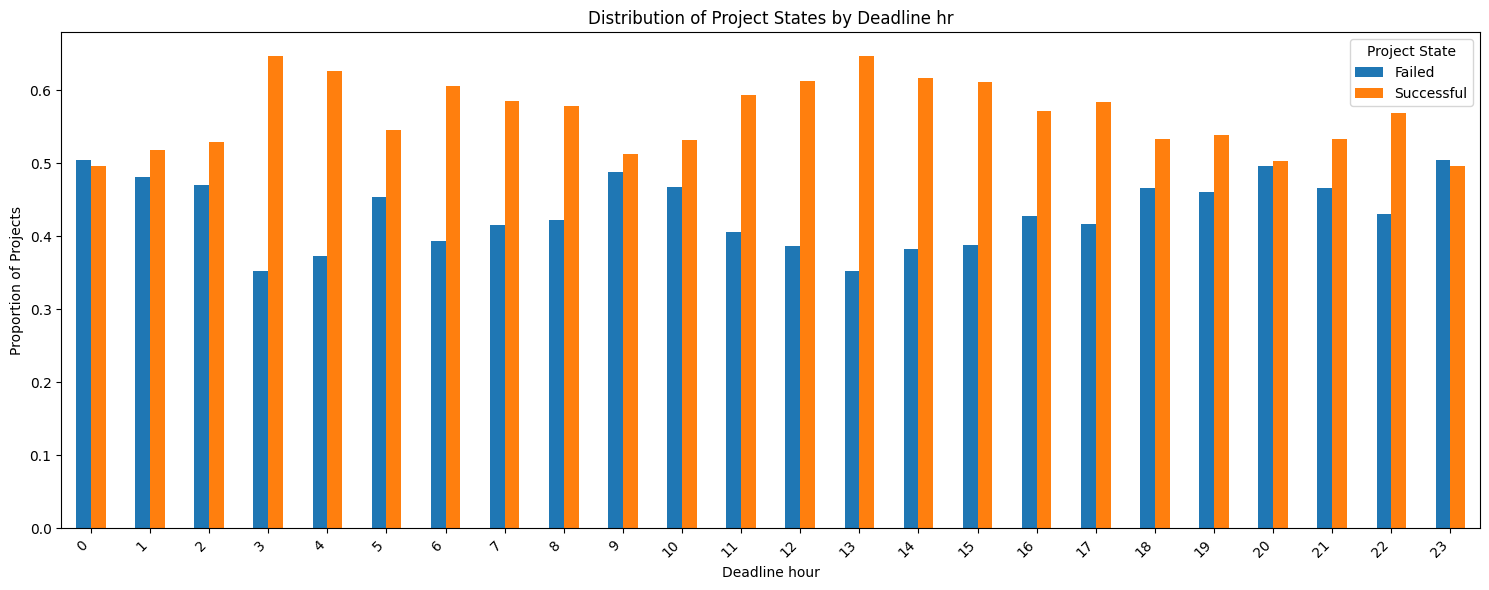

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Group data by country and state, then count occurrences
country_state_counts = kickstarter_df.groupby('deadline_hr')['state'].value_counts(normalize=True).unstack()

# Display the distribution as a bar chart
country_state_counts.plot(kind='bar', figsize=(15, 6))
plt.title('Distribution of Project States by Deadline hr')
plt.xlabel('Deadline hour')
plt.ylabel('Proportion of Projects')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend(title='Project State', labels=['Failed', 'Successful']) # Explicitly set legend labels
plt.tight_layout()
plt.show()

The distribution shows that projects having certain deadline hour have higher successful rates than the others.

Checking distribution of states of project by month created

In [ ]:
# Group by deadline weekday and state, then calculate the percentage
weekday_state_percentage = kickstarter_df.groupby('created_at_month')['state'].value_counts(normalize=True) * 100

# Display the percentage distribution
weekday_state_percentage

created_at_month  state
1                 1        57.555556
                  0        42.444444
2                 1        56.589147
                  0        43.410853
3                 1        57.088704
                  0        42.911296
4                 1        58.219178
                  0        41.780822
5                 1        56.140351
                  0        43.859649
6                 1        53.448276
                  0        46.551724
7                 1        56.318914
                  0        43.681086
8                 1        56.401384
                  0        43.598616
9                 1        58.890701
                  0        41.109299
10                1        56.390977
                  0        43.609023
11                1        58.275261
                  0        41.724739
12                1        58.919470
                  0        41.080530
Name: proportion, dtype: float64

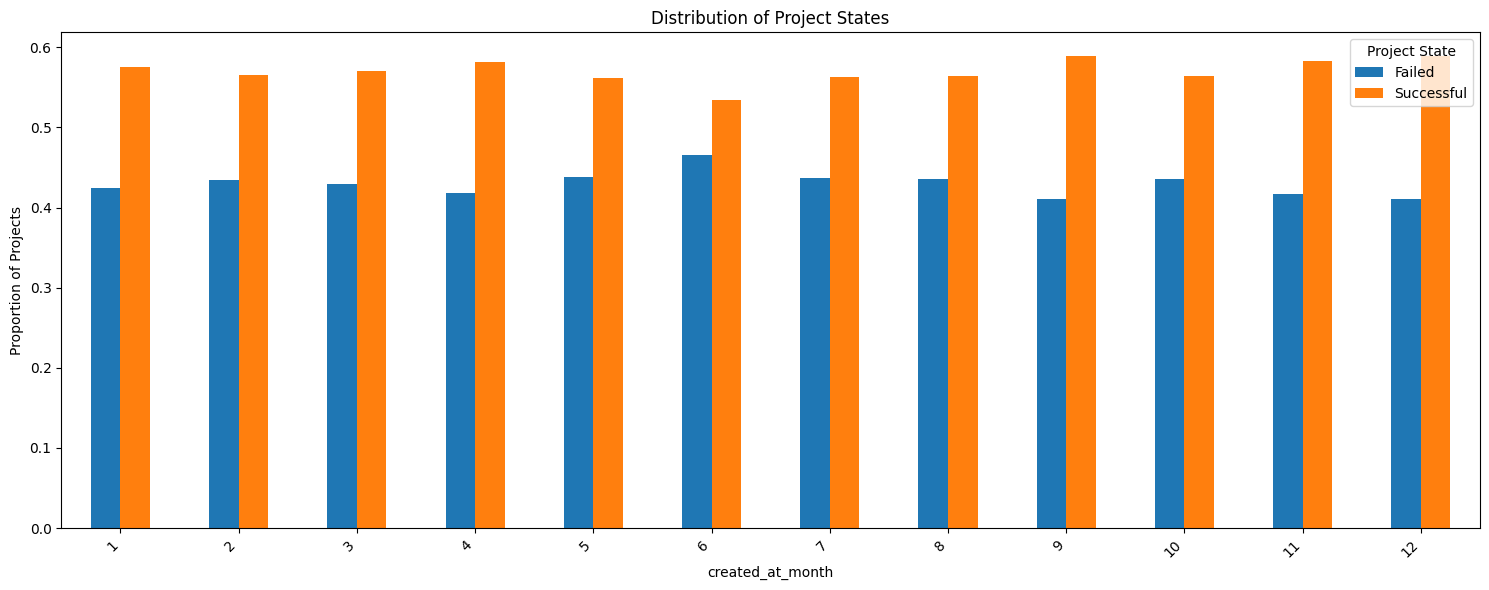

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Group data by country and state, then count occurrences
country_state_counts = kickstarter_df.groupby('created_at_month')['state'].value_counts(normalize=True).unstack()

# Display the distribution as a bar chart
country_state_counts.plot(kind='bar', figsize=(15, 6))
plt.title('Distribution of Project States')
plt.xlabel('created_at_month')
plt.ylabel('Proportion of Projects')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend(title='Project State', labels=['Failed', 'Successful']) # Explicitly set legend labels
plt.tight_layout()
plt.show()

The distribution shows that projects created in June have lower successful rates than the other months.

Checking distribution of states of project by day created

In [ ]:
# Group by deadline weekday and state, then calculate the percentage
weekday_state_percentage = kickstarter_df.groupby('created_at_day')['state'].value_counts(normalize=True) * 100

# Display the percentage distribution
weekday_state_percentage

created_at_day  state
1               1        58.021978
                0        41.978022
2               1        54.897959
                0        45.102041
3               1        55.625000
                0        44.375000
4               1        55.395683
                0        44.604317
5               1        57.843137
                0        42.156863
6               1        55.600815
                0        44.399185
7               1        57.053942
                0        42.946058
8               1        55.602537
                0        44.397463
9               1        57.983193
                0        42.016807
10              1        55.705996
                0        44.294004
11              1        56.680162
                0        43.319838
12              1        52.462527
                0        47.537473
13              1        57.818930
                0        42.181070
14              1        58.627859
                0        41.372141
15              1        63.440860
                0        36.559140
16              1        58.333333
                0        41.666667
17              1        58.666667
                0        41.333333
18              1        54.115226
                0        45.884774
19              1        61.445783
                0        38.554217
20              1        55.299539
                0        44.700461
21              1        54.441913
                0        45.558087
22              1        51.746725
                0        48.253275
23              1        56.367432
                0        43.632568
24              1        58.783784
                0        41.216216
25              1        56.553398
                0        43.446602
26              1        63.615561
                0        36.384439
27              1        56.521739
                0        43.478261
28              1        61.923077
                0        38.076923
29              1        57.882883
                0        42.117117
30              1        53.712871
                0        46.287129
31              1        53.386454
                0        46.613546
Name: proportion, dtype: float64

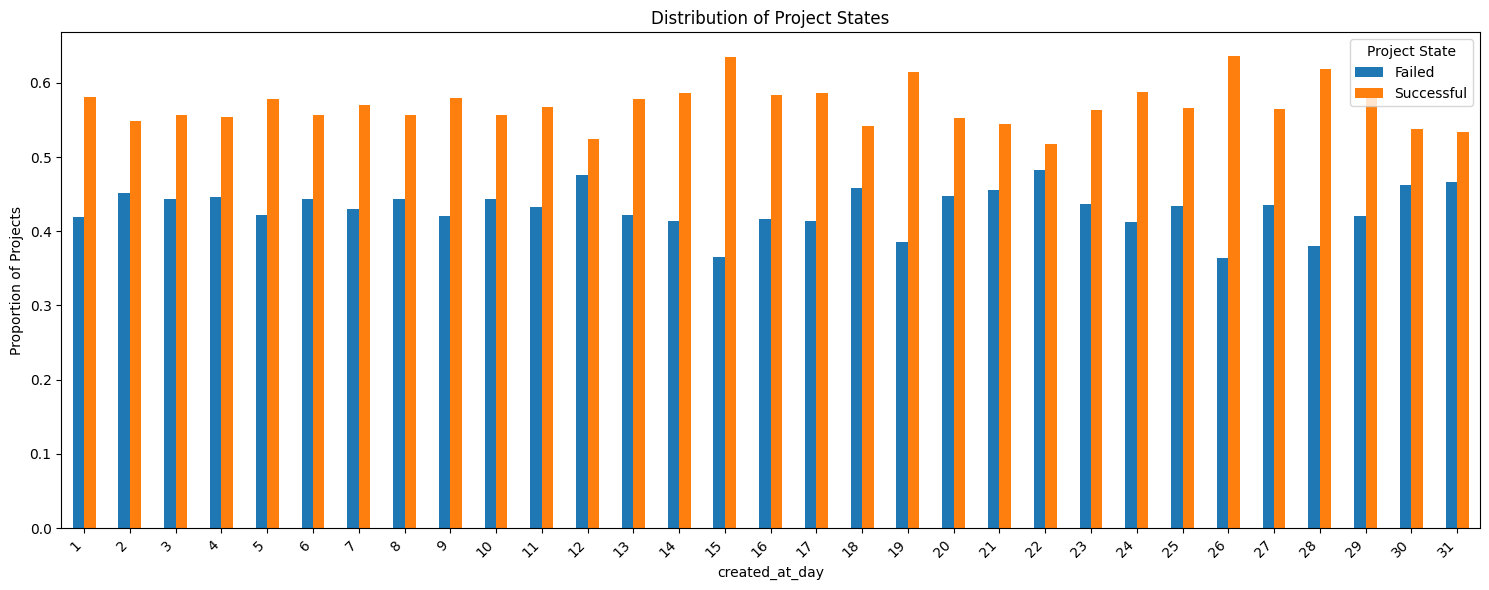

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Group data by country and state, then count occurrences
country_state_counts = kickstarter_df.groupby('created_at_day')['state'].value_counts(normalize=True).unstack()

# Display the distribution as a bar chart
country_state_counts.plot(kind='bar', figsize=(15, 6))
plt.title('Distribution of Project States')
plt.xlabel('created_at_day')
plt.ylabel('Proportion of Projects')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend(title='Project State', labels=['Failed', 'Successful']) # Explicitly set legend labels
plt.tight_layout()
plt.show()

The distribution shows that projects created on certain days have higher successful rates than the other days.

Checking distribution of states of project by year created

In [ ]:
# Group by deadline weekday and state, then calculate the percentage
weekday_state_percentage = kickstarter_df.groupby('created_at_yr')['state'].value_counts(normalize=True) * 100

# Display the percentage distribution
weekday_state_percentage

created_at_yr  state
2011           1        100.000000
2012           1         72.727273
               0         27.272727
2013           1         69.565217
               0         30.434783
2014           0         53.333333
               1         46.666667
2015           0         58.333333
               1         41.666667
2016           1         51.903114
               0         48.096886
2017           0         52.691218
               1         47.308782
2018           1         50.249207
               0         49.750793
2019           1         52.353227
               0         47.646773
2020           1         61.401777
               0         38.598223
2021           1         62.850242
               0         37.149758
2022           1         69.578544
               0         30.421456
Name: proportion, dtype: float64

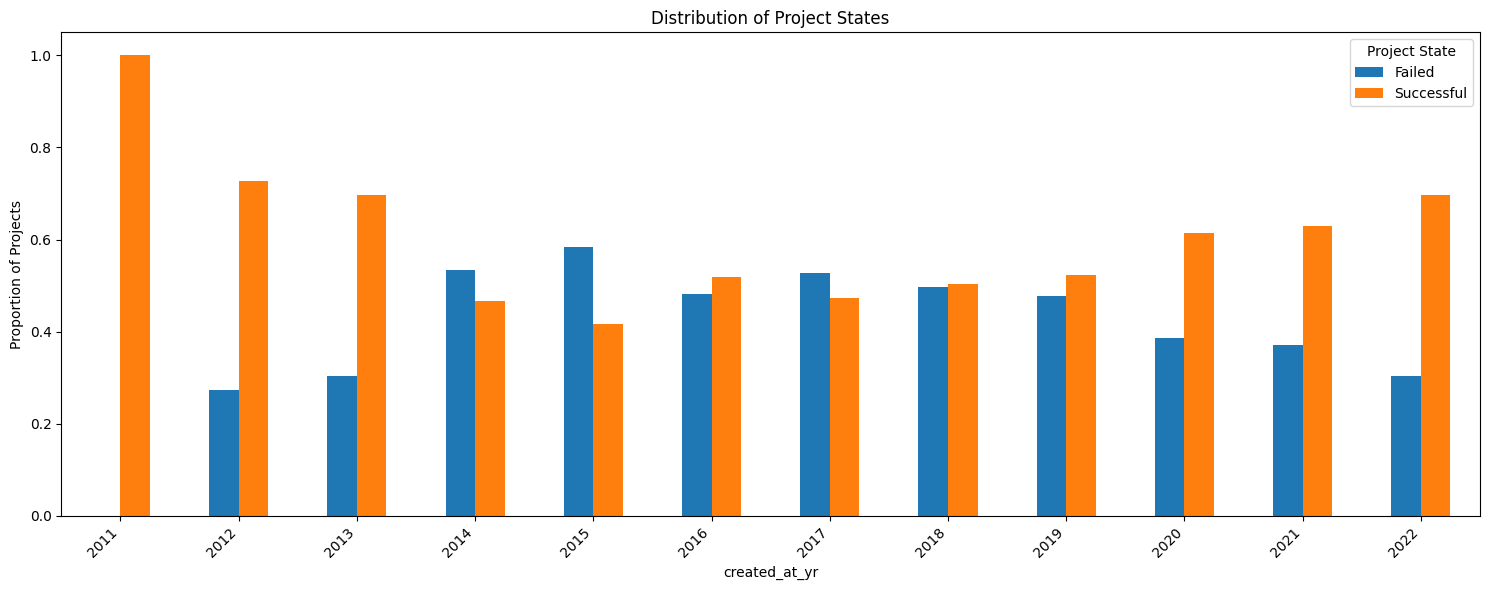

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Group data by country and state, then count occurrences
country_state_counts = kickstarter_df.groupby('created_at_yr')['state'].value_counts(normalize=True).unstack()

# Display the distribution as a bar chart
country_state_counts.plot(kind='bar', figsize=(15, 6))
plt.title('Distribution of Project States')
plt.xlabel('created_at_yr')
plt.ylabel('Proportion of Projects')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend(title='Project State', labels=['Failed', 'Successful']) # Explicitly set legend labels
plt.tight_layout()
plt.show()

The distribution shows that projects created in certain year have higher successful rates than the other.

Checking distribution of states of project by state created

In [ ]:
# Group by deadline weekday and state, then calculate the percentage
weekday_state_percentage = kickstarter_df.groupby('created_at_hr')['state'].value_counts(normalize=True) * 100

# Display the percentage distribution
weekday_state_percentage

created_at_hr  state
0              1        54.850088
               0        45.149912
1              1        53.187614
               0        46.812386
2              1        52.473498
               0        47.526502
3              1        54.105263
               0        45.894737
4              1        54.481132
               0        45.518868
5              1        56.024096
               0        43.975904
6              1        53.947368
               0        46.052632
7              1        55.704698
               0        44.295302
8              1        54.629630
               0        45.370370
9              1        55.269923
               0        44.730077
10             1        57.793765
               0        42.206235
11             1        55.352480
               0        44.647520
12             1        56.953642
               0        43.046358
13             1        58.520900
               0        41.479100
14             1        59.701493
               0        40.298507
15             1        55.444305
               0        44.555695
16             1        57.808858
               0        42.191142
17             1        56.333333
               0        43.666667
18             1        58.830022
               0        41.169978
19             1        59.507830
               0        40.492170
20             1        58.323766
               0        41.676234
21             1        60.129032
               0        39.870968
22             1        59.860140
               0        40.139860
23             1        57.894737
               0        42.105263
Name: proportion, dtype: float64

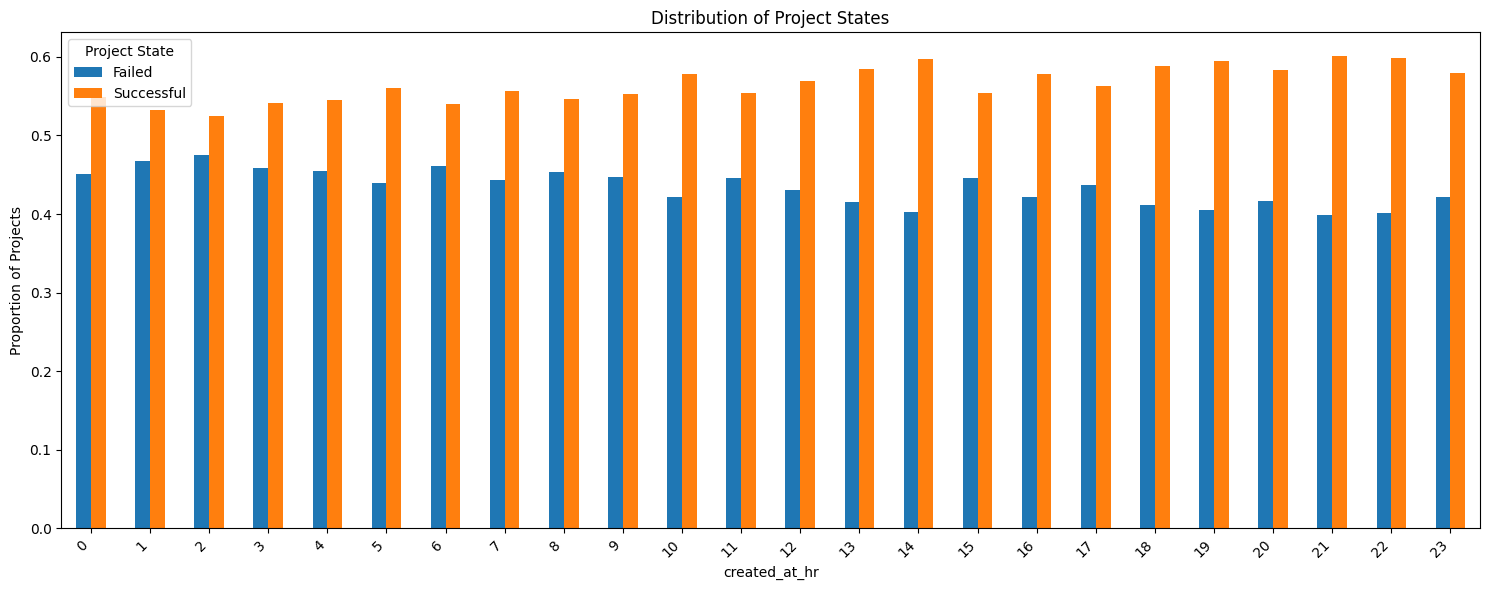

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Group data by country and state, then count occurrences
country_state_counts = kickstarter_df.groupby('created_at_hr')['state'].value_counts(normalize=True).unstack()

# Display the distribution as a bar chart
country_state_counts.plot(kind='bar', figsize=(15, 6))
plt.title('Distribution of Project States')
plt.xlabel('created_at_hr')
plt.ylabel('Proportion of Projects')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend(title='Project State', labels=['Failed', 'Successful']) # Explicitly set legend labels
plt.tight_layout()
plt.show()

The distribution shows that projects created at certain hour have higher successful rates than the other.

Checking distribution of states of project by month launched

In [ ]:
# Group by deadline weekday and state, then calculate the percentage
weekday_state_percentage = kickstarter_df.groupby('launched_at_month')['state'].value_counts(normalize=True) * 100

# Display the percentage distribution
weekday_state_percentage

launched_at_month  state
1                  1        58.148432
                   0        41.851568
2                  1        58.561644
                   0        41.438356
3                  1        60.551124
                   0        39.448876
4                  1        57.540017
                   0        42.459983
5                  1        56.050955
                   0        43.949045
6                  1        55.004352
                   0        44.995648
7                  1        52.537845
                   0        47.462155
8                  1        57.104558
                   0        42.895442
9                  1        56.390977
                   0        43.609023
10                 1        60.917839
                   0        39.082161
11                 1        55.996549
                   0        44.003451
12                 1        52.278481
                   0        47.721519
Name: proportion, dtype: float64

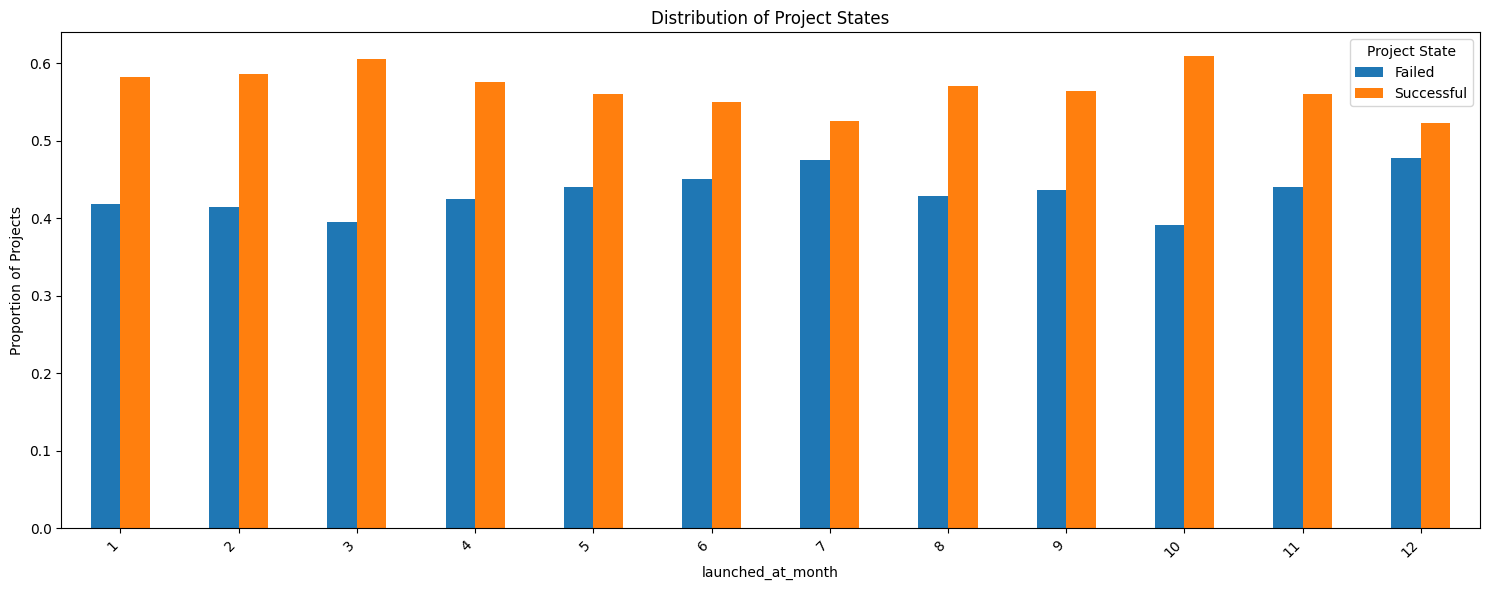

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Group data by country and state, then count occurrences
country_state_counts = kickstarter_df.groupby('launched_at_month')['state'].value_counts(normalize=True).unstack()

# Display the distribution as a bar chart
country_state_counts.plot(kind='bar', figsize=(15, 6))
plt.title('Distribution of Project States')
plt.xlabel('launched_at_month')
plt.ylabel('Proportion of Projects')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend(title='Project State', labels=['Failed', 'Successful']) # Explicitly set legend labels
plt.tight_layout()
plt.show()

The distribution shows that projects launched in certain month have higher successful rates than the other.

Checking distribution of states of project by day launched

In [ ]:
# Group by deadline weekday and state, then calculate the percentage
weekday_state_percentage = kickstarter_df.groupby('launched_at_day')['state'].value_counts(normalize=True) * 100

# Display the percentage distribution
weekday_state_percentage

launched_at_day  state
1                1        66.666667
                 0        33.333333
2                1        55.991736
                 0        44.008264
3                1        58.134490
                 0        41.865510
4                1        55.364807
                 0        44.635193
5                1        56.209150
                 0        43.790850
6                1        54.831461
                 0        45.168539
7                1        53.535354
                 0        46.464646
8                1        55.075594
                 0        44.924406
9                1        53.944563
                 0        46.055437
10               1        55.928854
                 0        44.071146
11               1        56.179775
                 0        43.820225
12               1        56.367432
                 0        43.632568
13               1        55.698925
                 0        44.301075
14               1        57.242991
                 0        42.757009
15               1        62.592593
                 0        37.407407
16               1        54.669704
                 0        45.330296
17               1        57.207207
                 0        42.792793
18               1        58.620690
                 0        41.379310
19               1        55.344418
                 0        44.655582
20               1        57.623318
                 0        42.376682
21               1        56.329114
                 0        43.670886
22               1        54.059829
                 0        45.940171
23               1        57.007126
                 0        42.992874
24               1        59.147870
                 0        40.852130
25               1        55.427252
                 0        44.572748
26               1        53.658537
                 0        46.341463
27               1        52.739726
                 0        47.260274
28               1        55.555556
                 0        44.444444
29               1        58.395990
                 0        41.604010
30               1        58.651685
                 0        41.348315
31               1        65.055762
                 0        34.944238
Name: proportion, dtype: float64

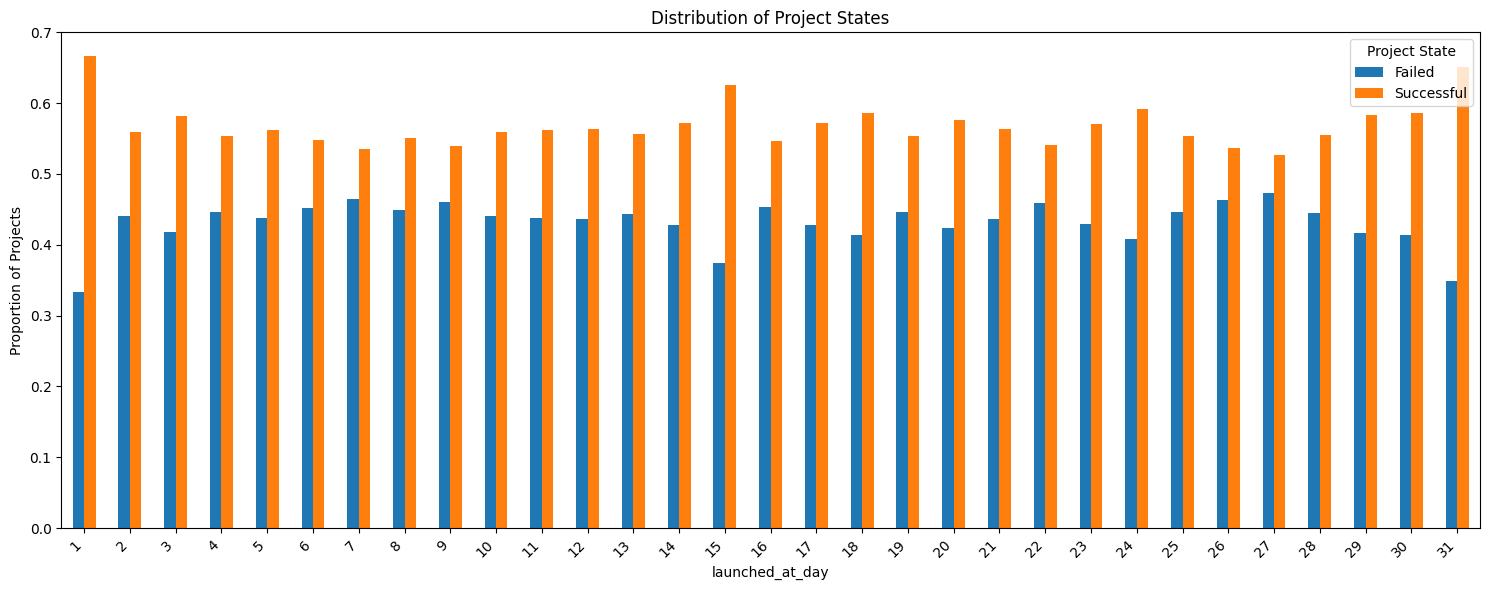

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Group data by country and state, then count occurrences
country_state_counts = kickstarter_df.groupby('launched_at_day')['state'].value_counts(normalize=True).unstack()

# Display the distribution as a bar chart
country_state_counts.plot(kind='bar', figsize=(15, 6))
plt.title('Distribution of Project States')
plt.xlabel('launched_at_day')
plt.ylabel('Proportion of Projects')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend(title='Project State', labels=['Failed', 'Successful']) # Explicitly set legend labels
plt.tight_layout()
plt.show()

The distribution shows that projects launched on certain days have higher successful rates than the other.

Checking distribution of states of project by year launched

In [ ]:
# Group by deadline weekday and state, then calculate the percentage
weekday_state_percentage = kickstarter_df.groupby('launched_at_yr')['state'].value_counts(normalize=True) * 100

# Display the percentage distribution
weekday_state_percentage

launched_at_yr  state
2017            0        52.497416
                1        47.502584
2018            0        50.088339
                1        49.911661
2019            1        51.495831
                0        48.504169
2020            1        59.763618
                0        40.236382
2021            1        62.147716
                0        37.852284
2022            1        68.120000
                0        31.880000
2023            1        79.577465
                0        20.422535
2024            1        89.795918
                0        10.204082
Name: proportion, dtype: float64

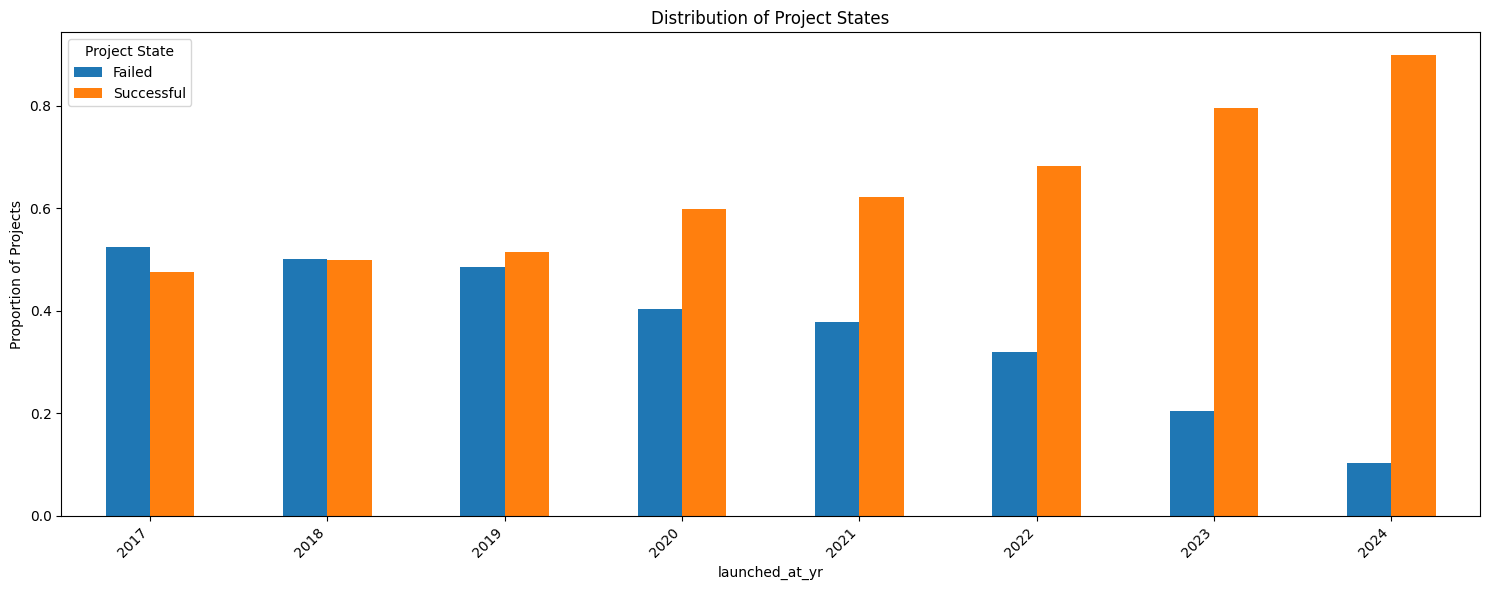

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Group data by country and state, then count occurrences
country_state_counts = kickstarter_df.groupby('launched_at_yr')['state'].value_counts(normalize=True).unstack()

# Display the distribution as a bar chart
country_state_counts.plot(kind='bar', figsize=(15, 6))
plt.title('Distribution of Project States')
plt.xlabel('launched_at_yr')
plt.ylabel('Proportion of Projects')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend(title='Project State', labels=['Failed', 'Successful']) # Explicitly set legend labels
plt.tight_layout()
plt.show()

The distribution shows that projects launched in recent years have higher successful rates than the other.

Checking distribution of states of project by hour launched

In [ ]:
# Group by deadline weekday and state, then calculate the percentage
weekday_state_percentage = kickstarter_df.groupby('launched_at_hr')['state'].value_counts(normalize=True) * 100

# Display the percentage distribution
weekday_state_percentage

launched_at_hr  state
0               0        52.941176
                1        47.058824
1               1        50.759219
                0        49.240781
2               0        55.357143
                1        44.642857
3               0        50.000000
                1        50.000000
4               0        50.677507
                1        49.322493
5               1        53.313253
                0        46.686747
6               1        53.684211
                0        46.315789
7               1        55.451713
                0        44.548287
8               1        54.597701
                0        45.402299
9               1        56.875000
                0        43.125000
10              1        58.290155
                0        41.709845
11              1        64.759725
                0        35.240275
12              1        66.093750
                0        33.906250
13              1        68.801898
                0        31.198102
14              1        63.932702
                0        36.067298
15              1        61.630219
                0        38.369781
16              1        63.041556
                0        36.958444
17              1        62.525458
                0        37.474542
18              1        56.862745
                0        43.137255
19              1        54.700855
                0        45.299145
20              0        52.676056
                1        47.323944
21              1        50.937951
                0        49.062049
22              0        51.114650
                1        48.885350
23              0        50.816697
                1        49.183303
Name: proportion, dtype: float64

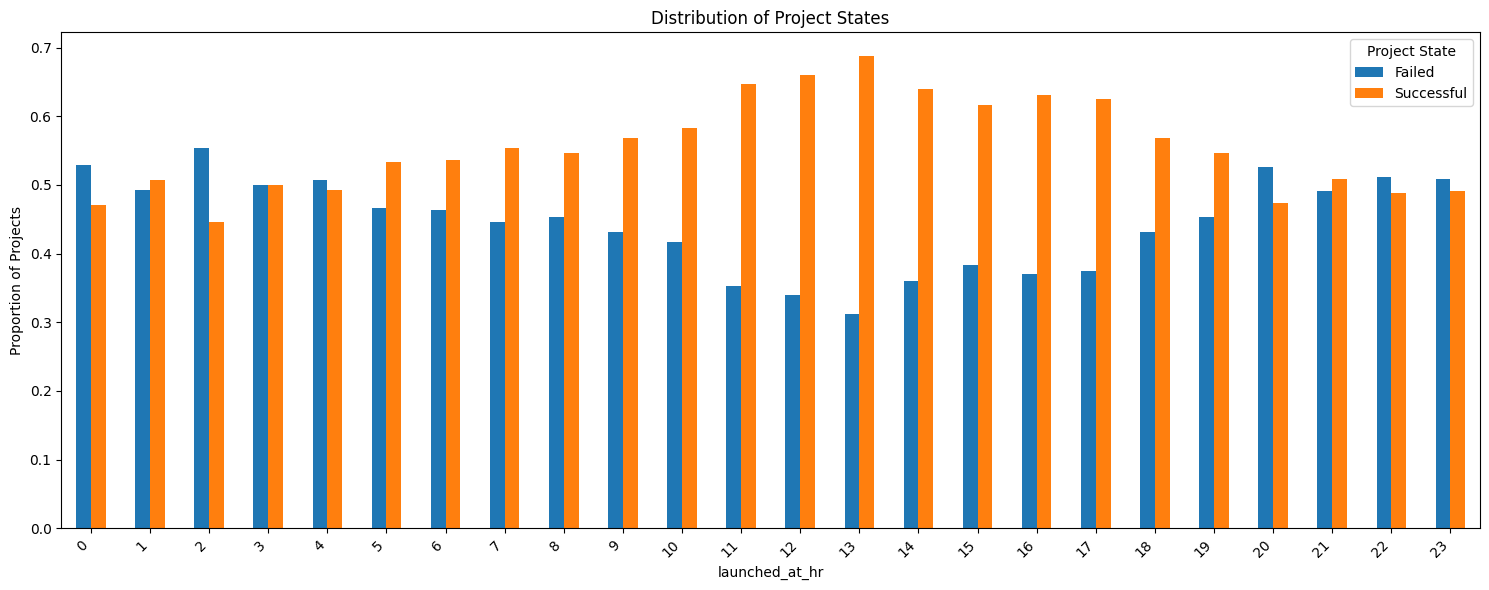

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Group data by country and state, then count occurrences
country_state_counts = kickstarter_df.groupby('launched_at_hr')['state'].value_counts(normalize=True).unstack()

# Display the distribution as a bar chart
country_state_counts.plot(kind='bar', figsize=(15, 6))
plt.title('Distribution of Project States')
plt.xlabel('launched_at_hr')
plt.ylabel('Proportion of Projects')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend(title='Project State', labels=['Failed', 'Successful']) # Explicitly set legend labels
plt.tight_layout()
plt.show()

The distribution shows that projects launched at certain hour have higher successful rates than the other.

Dropping column staff_pick.1 and staff_pick since they are future information


In [ ]:
kickstarter_df = kickstarter_df.drop(['staff_pick.1', 'staff_pick'], axis=1)

Checking the distribution wrt image present in the description or not

In [ ]:
kickstarter_df['show_feature_image'].value_counts()

,count
show_feature_image,
False,13720
True,465


Checking the distribution of 'show_feature_image' wrt state

In [ ]:
# Group by deadline weekday and state, then calculate the percentage
image_state_percentage = kickstarter_df.groupby('show_feature_image')['state'].value_counts(normalize=True) * 100

# Display the percentage distribution
image_state_percentage

show_feature_image  state
False               1         55.553936
                    0         44.446064
True                1        100.000000
Name: proportion, dtype: float64

Checking the distribution of 'video' wrt state

In [ ]:
# Group by deadline weekday and state, then calculate the percentage
video_state_percentage = kickstarter_df.groupby('video')['state'].value_counts(normalize=True) * 100

# Display the percentage distribution
video_state_percentage

video  state
False  0        52.560755
       1        47.439245
True   1        62.187704
       0        37.812296
Name: proportion, dtype: float64

The distribution of whether video was included or not clearly shows that the success rates are different for both.

Checking the distribution of 'main_category' wrt state

In [ ]:
kickstarter_df.groupby('main_category')['state'].value_counts()

main_category  state
Art            1         814
               0         655
Comics         1         130
               0          11
Crafts         0         355
               1         345
Dance          1          93
               0           9
Design         0         272
               1         216
Fashion        1         887
               0         383
Film & Video   1        1227
               0         812
Food           0        1024
               1         433
Games          1         522
               0         289
Journalism     0         270
               1         130
Music          1        1095
               0         511
Photography    1         418
               0         234
Publishing     1        1254
               0         452
Technology     0         730
               1         427
Theater        1          96
               0          91
Name: count, dtype: int64

In [ ]:
# Group by deadline weekday and state, then calculate the percentage
state_percentage = kickstarter_df.groupby('main_category')['state'].value_counts(normalize=True) * 100

# Display the percentage distribution
state_percentage

main_category  state
Art            1        55.411845
               0        44.588155
Comics         1        92.198582
               0         7.801418
Crafts         0        50.714286
               1        49.285714
Dance          1        91.176471
               0         8.823529
Design         0        55.737705
               1        44.262295
Fashion        1        69.842520
               0        30.157480
Film & Video   1        60.176557
               0        39.823443
Food           0        70.281400
               1        29.718600
Games          1        64.364982
               0        35.635018
Journalism     0        67.500000
               1        32.500000
Music          1        68.181818
               0        31.818182
Photography    1        64.110429
               0        35.889571
Publishing     1        73.505275
               0        26.494725
Technology     0        63.094209
               1        36.905791
Theater        1        51.336898
               0        48.663102
Name: proportion, dtype: float64

The distribution of state wrt category clearly shows that some categories have higher success rates than the others.

In [ ]:
kickstarter_df.columns

Index(['id', 'name', 'goal', 'state', 'country', 'currency', 'deadline',
       'created_at', 'launched_at', 'static_usd_rate', 'usd_pledged',
       'category', 'name_len', 'name_len_clean', 'blurb_len',
       'blurb_len_clean', 'deadline_weekday', 'created_at_weekday',
       'launched_at_weekday', 'deadline_month', 'deadline_day', 'deadline_yr',
       'deadline_hr', 'created_at_month', 'created_at_day', 'created_at_yr',
       'created_at_hr', 'launched_at_month', 'launched_at_day',
       'launched_at_yr', 'launched_at_hr', 'main_category',
       'show_feature_image', 'video', 'goal_quartile', 'deadline_year',
       'months_diff_bw_create_launch', 'months_diff_buckets',
       'months_diff_bw_launch_deadline'],
      dtype='object')

In [ ]:
kickstarter_df['goal_usd'] = kickstarter_df['static_usd_rate'] * kickstarter_df['goal']

In [ ]:
# Drop unneccesary predictors
kickstarter_df = kickstarter_df.drop(columns=['id', 'name','goal', 'static_usd_rate','usd_pledged'])
#'currency','name_len_clean','name_len','blurb_len'

In [ ]:
# X = kickstarter_df.drop('state', axis=1)
# X1 = X.copy()
# y = kickstarter_df['state']

# Treating Categorical Variables

In [ ]:
# Dummify variables - Part 1
kickstarter_df = pd.get_dummies(kickstarter_df)
# Dummify variables - Part 2
kickstarter_df = pd.get_dummies(kickstarter_df, columns = ['deadline_month','deadline_day','deadline_yr','deadline_hr'])
# Dummify variables - Part 3
kickstarter_df = pd.get_dummies(kickstarter_df, columns = ['created_at_month','created_at_day','created_at_yr','created_at_hr'])
# Dummify variables - Part 4
kickstarter_df = pd.get_dummies(kickstarter_df, columns = ['launched_at_month','launched_at_day','launched_at_yr','launched_at_hr'])


In [ ]:
# Get a list of columns with non-numeric data types
cols_to_drop = [col for col in kickstarter_df.columns if not pd.api.types.is_numeric_dtype(kickstarter_df[col])]

# Drop the columns
kickstarter_df = kickstarter_df.drop(columns=cols_to_drop, errors='ignore')

In [ ]:
kickstarter_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14185 entries, 0 to 15214
Columns: 548 entries, state to launched_at_hr_23
dtypes: bool(538), float64(3), int32(1), int64(6)
memory usage: 8.4 MB


In [ ]:
kickstarter_df.reset_index(drop=True, inplace=True)

# Anomalies detection

In [ ]:
# Removing anomalies with Isolation Forest

# Create isolation forest model
# Contamination parameter of 0.05 to get ~700 (~5%) of total anomalies (14214)
from sklearn.ensemble import IsolationForest
iforest = IsolationForest(n_estimators=100, contamination=.05, random_state = 5)
pred = iforest.fit_predict(kickstarter_df)
score = iforest.decision_function(kickstarter_df)

In [ ]:
# Extracting anomalies
from numpy import where
anom_index = where(pred==-1)
values = kickstarter_df.iloc[anom_index]

# Remove anomalies from dataset
kickstarter_df = pd.concat([kickstarter_df, values, values]).drop_duplicates(keep=False)
X = kickstarter_df.loc[:, kickstarter_df.columns != 'state']
y = kickstarter_df['state']

### Drop highly correlated columns

In [ ]:
# Drop columns name_len and blurb_len

kickstarter_df = kickstarter_df.drop(columns=['name_len', 'blurb_len'])

# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
import numpy as np

# Fit logistic regression model
log_reg = LogisticRegression(max_iter=1000, random_state=5)
log_reg.fit(X, y)

# Get feature importance
feature_importance = np.abs(log_reg.coef_[0])
feature_names = X.columns

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Select the top 10 important features
top_features = feature_importance_df.head(40)['Feature'].values
X_top = X[top_features]

from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_top, y, test_size=0.2, random_state=5)

# Fit logistic regression model with top features
log_reg_top = LogisticRegression(max_iter=1000, random_state=5)

# Fit logistic regression model with top features on the training set
log_reg_top.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000, random_state=5)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Assuming y_pred contains the predicted values for the test set
y_pred = log_reg_top.predict(X_test)

# Calculate the metrics
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")
print(f"Accuracy: {accuracy:.3f}")

Precision: 0.793
Recall: 0.766
F1-score: 0.779
Accuracy: 0.748


# Decision Tree Classifier

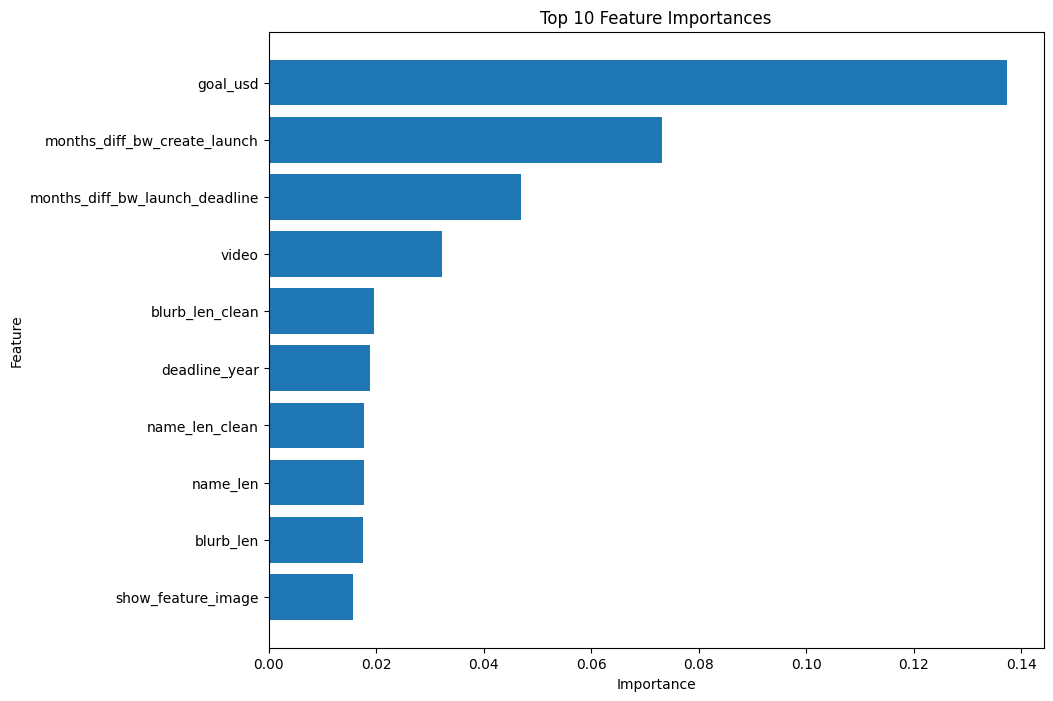

In [ ]:
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt

# Fit the decision tree model
dtree = DecisionTreeClassifier(random_state=5)
dtree.fit(X, y)

# Get feature importances
feature_importances = dtree.feature_importances_

# Create a DataFrame for better visualization
feature_importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(feature_importances_df['Feature'][:10], feature_importances_df['Importance'][:10])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# Filter features with importance greater than 0.005
important_features = feature_importances[feature_importances['importance'] > 0.005].index
X_important = X[important_features]

# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the DecisionTreeClassifier
dtree = DecisionTreeClassifier(random_state=5)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=dtree, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(X_important, y)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

# Show the best model results
best_model = grid_search.best_estimator_
best_score = grid_search.best_score_

print("Best model: ", best_model)
print("Best cross-validation score: ", best_score)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters found:  {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10}
Best model:  DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_leaf=4,
                       min_samples_split=10, random_state=5)
Best cross-validation score:  0.7136178107606679


In [ ]:

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

important_features = feature_importances[feature_importances['importance'] > 0.005].index
X_important = X[important_features]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_important, y, test_size=0.2, random_state=5)

# Initialize and train the decision tree classifier with specified parameters
dtree = DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_leaf=4, min_samples_split=2, random_state=5)
dtree.fit(X_train, y_train)

# Make predictions on the test set
y_pred = dtree.predict(X_test)

# Calculate the metrics
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")
print(f"Accuracy: {accuracy:.3f}")

Precision: 0.733
Recall: 0.780
F1-score: 0.756
Accuracy: 0.716


# Random forest model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Initialize and train the RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X, y)

# Get feature importances
importances = rf_model.feature_importances_

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

In [ ]:
from sklearn.model_selection import GridSearchCV
# Filter features with importance greater than 0.005
important_features = feature_importance_df[feature_importance_df['Importance'] > 0.005]['Feature'].tolist()
X_important = X[important_features]

# Define the parameter grid for RandomForestClassifier
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a RandomForestClassifier
rf_model_important = RandomForestClassifier(random_state=42)

# Use GridSearchCV to find the best parameters
grid_search = GridSearchCV(estimator=rf_model_important, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_important, y)

# Print the best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
Best score: 0.6231539888682746


In [ ]:

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Filter features with importance greater than 0.005
important_features = feature_importance_df[feature_importance_df['Importance'] > 0.005]['Feature'].tolist()
X_important = X[important_features]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_important, y, test_size=0.2, random_state=5)

# Initialize and train the Decision Tree Classifier with specified parameters
dtree = DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_leaf=4, min_samples_split=2, random_state=5)
dtree.fit(X_train, y_train)

# Make predictions on the test set
y_pred = dtree.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the decision tree model: {accuracy}")

Accuracy of the decision tree model: 0.7068645640074211


In [ ]:

# Assuming y_test and y_pred are defined from the previous code (Random Forest model)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate the metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")

Accuracy: 0.707
Precision: 0.711
Recall: 0.808
F1-score: 0.756


# Gradient Boosting Model

Model Accuracy: 0.77


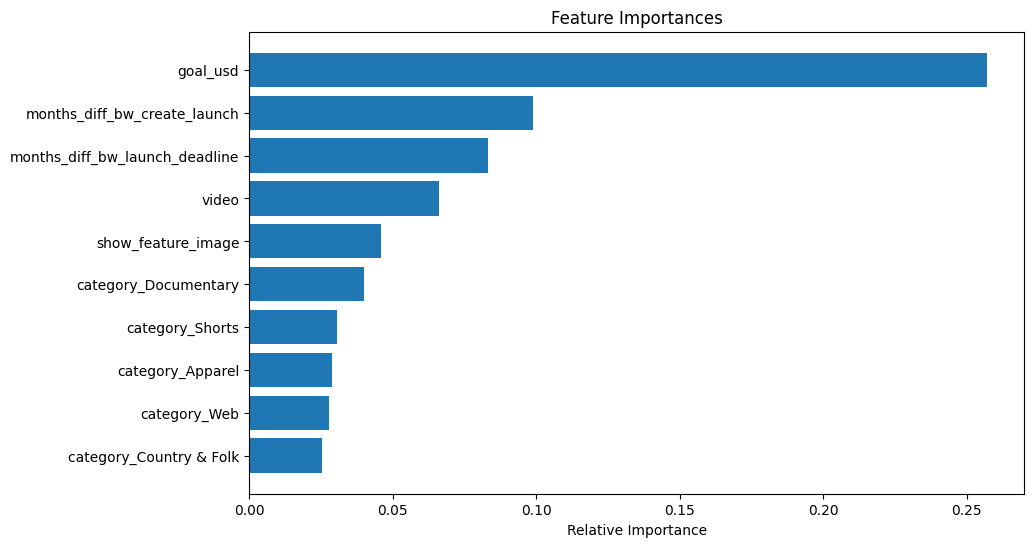

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

import matplotlib.pyplot as plt
X = kickstarter_df.loc[:, kickstarter_df.columns != 'state']
y = kickstarter_df['state']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the model
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = gb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

# Get feature importances
feature_importances = gb_model.feature_importances_

# Plot feature importances
indices = np.argsort(feature_importances)[-10:]  # Top 10 features
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.barh(range(len(indices)), feature_importances[indices], align="center")
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

In [ ]:
feature_importances = pd.DataFrame(feature_importances, index = X.columns, columns=['importance']).sort_values('importance', ascending=False)

In [ ]:
from sklearn.model_selection import GridSearchCV

# Filter features with importance > 0.005
important_features = feature_importances[feature_importances['importance'] > 0.005].index
X_important = X[important_features]

# Split the data into training and testing sets
X_train_imp, X_test_imp, y_train_imp, y_test_imp = train_test_split(X_important, y, test_size=0.2, random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=GradientBoostingClassifier(random_state=42), param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(X_train_imp, y_train_imp)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")

# Evaluate the best model
best_gb_model = grid_search.best_estimator_
y_pred_imp = best_gb_model.predict(X_test_imp)
accuracy_imp = accuracy_score(y_test_imp, y_pred_imp)
print(f"Model Accuracy with important features: {accuracy_imp:.2f}")

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best parameters found: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Model Accuracy with important features: 0.77


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Assuming X_train_imp, y_train_imp are defined from previous code
# and you want to use the specified parameters
# Filter features with importance > 0.005
important_features = feature_importances[feature_importances['importance'] > 0.005].index
X_important = X[important_features]

# Split the data into training and testing sets
X_train_imp, X_test_imp, y_train_imp, y_test_imp = train_test_split(X_important, y, test_size=0.2, random_state=42)

gb_model = GradientBoostingClassifier(
    learning_rate=0.1,
    max_depth=4,
    min_samples_leaf=2,
    min_samples_split=5,
    n_estimators=200,
    random_state=42
)

gb_model.fit(X_train_imp, y_train_imp)

y_pred_imp = gb_model.predict(X_test_imp)
accuracy_imp = accuracy_score(y_test_imp, y_pred_imp)
print(f"Model Accuracy with important features: {accuracy_imp:.3f}")

Model Accuracy with important features: 0.769


In [ ]:

accuracy = accuracy_score(y_test_imp, y_pred_imp)
precision = precision_score(y_test_imp, y_pred_imp, pos_label=1)
recall = recall_score(y_test_imp, y_pred_imp, pos_label=1)
f1 = f1_score(y_test_imp, y_pred_imp, pos_label=1)

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")

Accuracy: 0.769
Precision: 0.783
Recall: 0.825
F1-score: 0.804


# Task 1: Final Regression Model

In [76]:
import pandas as pd
import numpy as np

kickstarter_df = pd.read_excel("Kickstarter.xlsx")

# Clean and pre-select Data
kickstarter_df = kickstarter_df.dropna()

# Keeping the rows where state is successful or failed else drop
kickstarter_df = kickstarter_df[kickstarter_df['state'].isin(['successful', 'failed'])]

kickstarter_df['state'] = kickstarter_df['state'].apply(lambda x: 1 if x=='successful' else 0)

kickstarter_df = kickstarter_df.drop(columns=['backers_count','pledged','state_changed_at_month','state_changed_at_day', 'state_changed_at_yr', 'state_changed_at_hr','state_changed_at_weekday'], errors='ignore')

# Dropping column "disable_communication"
kickstarter_df = kickstarter_df.drop(['disable_communication'], axis=1)

kickstarter_df = kickstarter_df.drop(columns=['state_changed_at'], errors='ignore')

# Calculate the difference between 'launched_at' and 'created_at' in months
kickstarter_df['launched_at'] = pd.to_datetime(kickstarter_df['launched_at'])
kickstarter_df['created_at'] = pd.to_datetime(kickstarter_df['created_at'])
kickstarter_df['months_diff_bw_create_launch'] = (kickstarter_df['launched_at'] - kickstarter_df['created_at']).dt.days / 30

# Create month difference buckets
bins = [0, 1, 3, 6, 12, float('inf')]
labels = ['0-1 Month', '1-3 Months', '3-6 Months', '6-12 Months', '12+ Months']
kickstarter_df['months_diff_buckets'] = pd.cut(kickstarter_df['months_diff_bw_create_launch'], bins=bins, labels=labels, right=False)

# Calculate the difference between 'launched_at' and 'created_at' in months
kickstarter_df['launched_at'] = pd.to_datetime(kickstarter_df['launched_at'])
kickstarter_df['deadline'] = pd.to_datetime(kickstarter_df['deadline'])
kickstarter_df['months_diff_bw_launch_deadline'] = (kickstarter_df['launched_at'] - kickstarter_df['deadline']).dt.days / 30

# Dropping column "spotlight"
kickstarter_df = kickstarter_df.drop(['spotlight'], axis=1)

kickstarter_df = kickstarter_df.drop(['staff_pick.1', 'staff_pick'], axis=1)

kickstarter_df['goal_usd'] = kickstarter_df['static_usd_rate'] * kickstarter_df['goal']

# Drop unneccesary predictors
kickstarter_df = kickstarter_df.drop(columns=['id', 'name','goal', 'static_usd_rate','usd_pledged'])

# Dummify variables - Part 1
kickstarter_df = pd.get_dummies(kickstarter_df)
# Dummify variables - Part 2
kickstarter_df = pd.get_dummies(kickstarter_df, columns = ['deadline_month','deadline_day','deadline_yr','deadline_hr'])
# Dummify variables - Part 3
kickstarter_df = pd.get_dummies(kickstarter_df, columns = ['created_at_month','created_at_day','created_at_yr','created_at_hr'])
# Dummify variables - Part 4
kickstarter_df = pd.get_dummies(kickstarter_df, columns = ['launched_at_month','launched_at_day','launched_at_yr','launched_at_hr'])

# Get a list of columns with non-numeric data types
cols_to_drop = [col for col in kickstarter_df.columns if not pd.api.types.is_numeric_dtype(kickstarter_df[col])]

# Drop the columns
kickstarter_df = kickstarter_df.drop(columns=cols_to_drop, errors='ignore')

kickstarter_df.reset_index(drop=True, inplace=True)

# Drop columns name_len and blurb_len

kickstarter_df = kickstarter_df.drop(columns=['name_len', 'blurb_len'])

# Removing anomalies with Isolation Forest

# Create isolation forest model
# Contamination parameter of 0.05 to get ~700 (~5%) of total anomalies (14214)
from sklearn.ensemble import IsolationForest
iforest = IsolationForest(n_estimators=100, contamination=.05, random_state = 5)
pred = iforest.fit_predict(kickstarter_df)
score = iforest.decision_function(kickstarter_df)

# Extracting anomalies
from numpy import where
anom_index = where(pred==-1)
values = kickstarter_df.iloc[anom_index]

# Remove anomalies from dataset
kickstarter_df = pd.concat([kickstarter_df, values, values]).drop_duplicates(keep=False)
X = kickstarter_df.loc[:, kickstarter_df.columns != 'state']
y = kickstarter_df['state']

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

import matplotlib.pyplot as plt
X = kickstarter_df.loc[:, kickstarter_df.columns != 'state']
y = kickstarter_df['state']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the model
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = gb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
# print(f"Model Accuracy: {accuracy:.2f}")

# Get feature importances
feature_importances = gb_model.feature_importances_

feature_importances = pd.DataFrame(feature_importances, index = X.columns, columns=['importance']).sort_values('importance', ascending=False)

from sklearn.model_selection import GridSearchCV

# Filter features with importance > 0.005
important_features = feature_importances[feature_importances['importance'] > 0.005].index
X_important = X[important_features]

# Split the data into training and testing sets
X_train_imp, X_test_imp, y_train_imp, y_test_imp = train_test_split(X_important, y, test_size=0.2, random_state=42)

# Create and fit the model with specified parameters
gb_model_tuned = GradientBoostingClassifier(learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=300, random_state=42)
gb_model_tuned.fit(X_train_imp, y_train_imp)

# Predict and evaluate the tuned model
y_pred_tuned = gb_model_tuned.predict(X_test_imp)
accuracy_tuned = accuracy_score(y_test_imp, y_pred_tuned)
print(f"Tuned Model Accuracy: {accuracy_tuned:.2f}")


# Assuming y_test and y_pred are defined from the previous code (Random Forest model)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test_imp, y_pred_tuned)
precision = precision_score(y_test_imp, y_pred_tuned, pos_label=1)
recall = recall_score(y_test_imp, y_pred_tuned, pos_label=1)
f1 = f1_score(y_test_imp, y_pred_tuned, pos_label=1)

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")


Model Accuracy: 0.78
Tuned Model Accuracy: 0.78
Accuracy: 0.778
Precision: 0.786
Recall: 0.827
F1-score: 0.806


# Grading using the Final Model

### Function for Pre-processing data

In [78]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from numpy import where
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def preprocess_data(kickstarter_df):

    # Clean and pre-select Data
    kickstarter_df = kickstarter_df.dropna()

    # Keeping the rows where state is successful or failed else drop
    kickstarter_df = kickstarter_df[kickstarter_df['state'].isin(['successful', 'failed'])]

    kickstarter_df['state'] = kickstarter_df['state'].apply(lambda x: 1 if x=='successful' else 0)

    kickstarter_df = kickstarter_df.drop(columns=['backers_count','pledged','state_changed_at_month','state_changed_at_day', 'state_changed_at_yr', 'state_changed_at_hr','state_changed_at_weekday'], errors='ignore')

    # Dropping column "disable_communication"
    kickstarter_df = kickstarter_df.drop(['disable_communication'], axis=1)

    kickstarter_df = kickstarter_df.drop(columns=['state_changed_at'], errors='ignore')

    # Calculate the difference between 'launched_at' and 'created_at' in months
    kickstarter_df['launched_at'] = pd.to_datetime(kickstarter_df['launched_at'])
    kickstarter_df['created_at'] = pd.to_datetime(kickstarter_df['created_at'])
    kickstarter_df['months_diff_bw_create_launch'] = (kickstarter_df['launched_at'] - kickstarter_df['created_at']).dt.days / 30

    # Create month difference buckets
    bins = [0, 1, 3, 6, 12, float('inf')]
    labels = ['0-1 Month', '1-3 Months', '3-6 Months', '6-12 Months', '12+ Months']
    kickstarter_df['months_diff_buckets'] = pd.cut(kickstarter_df['months_diff_bw_create_launch'], bins=bins, labels=labels, right=False)

    # Calculate the difference between 'launched_at' and 'created_at' in months
    kickstarter_df['launched_at'] = pd.to_datetime(kickstarter_df['launched_at'])
    kickstarter_df['deadline'] = pd.to_datetime(kickstarter_df['deadline'])
    kickstarter_df['months_diff_bw_launch_deadline'] = (kickstarter_df['launched_at'] - kickstarter_df['deadline']).dt.days / 30

    # Dropping column "spotlight"
    kickstarter_df = kickstarter_df.drop(['spotlight'], axis=1)

    kickstarter_df = kickstarter_df.drop(['staff_pick.1', 'staff_pick'], axis=1)

    kickstarter_df['goal_usd'] = kickstarter_df['static_usd_rate'] * kickstarter_df['goal']

    # Drop unneccesary predictors
    kickstarter_df = kickstarter_df.drop(columns=['id', 'name','goal', 'static_usd_rate','usd_pledged'])

    # Dummify variables - Part 1
    kickstarter_df = pd.get_dummies(kickstarter_df)
    # Dummify variables - Part 2
    kickstarter_df = pd.get_dummies(kickstarter_df, columns = ['deadline_month','deadline_day','deadline_yr','deadline_hr'])
    # Dummify variables - Part 3
    kickstarter_df = pd.get_dummies(kickstarter_df, columns = ['created_at_month','created_at_day','created_at_yr','created_at_hr'])
    # Dummify variables - Part 4
    kickstarter_df = pd.get_dummies(kickstarter_df, columns = ['launched_at_month','launched_at_day','launched_at_yr','launched_at_hr'])

    # Get a list of columns with non-numeric data types
    cols_to_drop = [col for col in kickstarter_df.columns if not pd.api.types.is_numeric_dtype(kickstarter_df[col])]

    # Drop the columns
    kickstarter_df = kickstarter_df.drop(columns=cols_to_drop, errors='ignore')

    kickstarter_df.reset_index(drop=True, inplace=True)

    # Drop columns name_len and blurb_len

    kickstarter_df = kickstarter_df.drop(columns=['name_len', 'blurb_len'])

    return kickstarter_df


# Load file and test the results (Change file path here)

In [80]:
# Load the new data
new_kickstarter_df = pd.read_excel("kickstarter_grading.xlsx")

# Preprocess the new data
preprocessed_data = preprocess_data(new_kickstarter_df)

#Important Features
important_features = ['goal_usd', 'months_diff_bw_create_launch','months_diff_bw_launch_deadline', 'video', 'show_feature_image','category_Documentary', 'category_Apparel', 'category_Shorts',"category_Children's Books", 'category_Web', 'main_category_Food','category_Country & Folk', 'category_Accessories', 'category_Rock','category_Art Books', 'category_Playing Cards', 'category_Mobile Games','category_Nonfiction', 'created_at_yr_2022', 'category_Video Games','name_len_clean', 'category_Indie Rock', 'category_Anthologies','category_Narrative Film', 'category_Photobooks']

# Handle missing columns in the new data
missing_cols = set(important_features) - set(preprocessed_data.columns)
for col in missing_cols:
    preprocessed_data[col] = 0

X_new = preprocessed_data[important_features]
# Ensure 'state' column exists
if 'state' not in preprocessed_data.columns:
    print("Error: 'state' column not found in the new data. Predictions cannot be evaluated.")
    exit() # Or handle the error differently

y_new = preprocessed_data['state']


#Check if the model is defined
if 'gb_model_tuned' not in locals():
    print("Error: The model 'gb_model_tuned' is not defined. Please train the model first.")
    exit()
# Make predictions
try:
    y_new_pred = gb_model_tuned.predict(X_new)

    accuracy = accuracy_score(y_new, y_new_pred)
    precision = precision_score(y_new, y_new_pred)
    recall = recall_score(y_new, y_new_pred)
    f1 = f1_score(y_new, y_new_pred)

    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1-score: {f1:.3f}")
except ValueError as e:
    print(f"Prediction error: {e}")


# Task 2: Clustering Model

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
# Import data
kickstarter_df = pd.read_excel("Kickstarter.xlsx")

## Preprocessing

In [ ]:

# Drop unneccesary predictors
kickstarter_df = kickstarter_df.drop(columns=['id', 'name'])
# Create goal in USD by converting goal with USD rate and drop 'goal' and 'static_usd_rate'. Drop them after.
kickstarter_df['goal_usd'] = kickstarter_df['goal'] * kickstarter_df['static_usd_rate']
kickstarter_df = kickstarter_df.drop(columns=['goal','static_usd_rate'])
kickstarter_df = kickstarter_df.dropna()
# Keeping the rows where state is successful or failed else drop
kickstarter_df = kickstarter_df[kickstarter_df['state'].isin(['successful', 'failed'])]
kickstarter_df['state'] = kickstarter_df['state'].apply(lambda x: 1 if x=='successful' else 0)
kickstarter_df = kickstarter_df.drop(columns=['state_changed_at'], errors='ignore')

# Dropping column "disable_communication"
kickstarter_df = kickstarter_df.drop(['disable_communication','name_len','blurb_len'], axis=1)

# Calculate the difference between 'launched_at' and 'created_at' in months
kickstarter_df['launched_at'] = pd.to_datetime(kickstarter_df['launched_at'])
kickstarter_df['created_at'] = pd.to_datetime(kickstarter_df['created_at'])
kickstarter_df['months_diff_bw_create_launch'] = (kickstarter_df['launched_at'] - kickstarter_df['created_at']).dt.days / 30


# Calculate the difference between 'launched_at' and 'created_at' in months
kickstarter_df['launched_at'] = pd.to_datetime(kickstarter_df['launched_at'])
kickstarter_df['deadline'] = pd.to_datetime(kickstarter_df['deadline'])
kickstarter_df['months_diff_bw_launch_deadline'] = (kickstarter_df['launched_at'] - kickstarter_df['deadline']).dt.days / 30

kickstarter_df = kickstarter_df.drop(columns=['launched_at','created_at','deadline'], errors='ignore')

kickstarter_df = kickstarter_df.drop(['staff_pick.1'], axis=1)

kickstarter_df = kickstarter_df.drop(['deadline_month','deadline_day','deadline_yr','deadline_hr','created_at_month','created_at_day','created_at_yr','created_at_hr','launched_at_month','launched_at_day','launched_at_yr','launched_at_hr'], axis=1)

# Get a list of columns with non-numeric data types
cols_to_drop = [col for col in kickstarter_df.columns if not pd.api.types.is_numeric_dtype(kickstarter_df[col])]

# Drop the columns
kickstarter_df = kickstarter_df.drop(columns=cols_to_drop, errors='ignore')

kickstarter_df = kickstarter_df.drop(columns='pledged', errors='ignore')
kickstarter_df = kickstarter_df.drop(columns=['deadline_weekday', 'state_changed_at_weekday',
       'created_at_weekday', 'launched_at_weekday', 'state_changed_at_month',
       'state_changed_at_day', 'state_changed_at_yr', 'state_changed_at_hr'], errors='ignore')

kickstarter_df = kickstarter_df.drop(columns=['country', 'currency'], errors='ignore')
kickstarter_df = kickstarter_df.drop(columns=['category', 'main_category'], errors='ignore')
kickstarter_df = kickstarter_df.drop(columns=['spotlight', 'staff_pick'], errors='ignore')


## Remove anomalies

In [ ]:
##############################################################################
# Removing anomalies with Isolation Forest

# Create isolation forest model
# Contamination parameter of 0.05 to get ~700 (~5%) of total anomalies (14214)
from sklearn.ensemble import IsolationForest
iforest = IsolationForest(n_estimators=100, contamination=.05, random_state = 5)
pred = iforest.fit_predict(kickstarter_df)
score = iforest.decision_function(kickstarter_df)

# Extracting anomalies
from numpy import where
anom_index = where(pred==-1)
values = kickstarter_df.iloc[anom_index]

#Remove anomalies from dataset
kickstarter_df = pd.concat([kickstarter_df, values, values]).drop_duplicates(keep=False)
kickstarter_df = kickstarter_df.reset_index(drop=True)  # Reset index

 ## Important features

In [ ]:
##############################################################################
# Feature Selection
X = kickstarter_df.loc[:, kickstarter_df.columns != 'usd_pledged']
y = kickstarter_df['usd_pledged']

##############################################################################
# Random forest for feature selection

from sklearn.ensemble import RandomForestRegressor
randomforest = RandomForestRegressor(random_state = 5)
model_classifier = randomforest.fit(X, y)

from sklearn.feature_selection import SelectFromModel
sfm = SelectFromModel(model_classifier)
sfm.fit(X, y)
coef_rf = pd.DataFrame(list(zip(X.columns,model_classifier.feature_importances_)), columns = ['predictor','Gini_coefficient']).sort_values('Gini_coefficient',ascending = False)
print(coef_rf)

                        predictor  Gini_coefficient
1                   backers_count          0.647228
6                        goal_usd          0.187227
7    months_diff_bw_create_launch          0.053184
3                 blurb_len_clean          0.036623
8  months_diff_bw_launch_deadline          0.027039
2                  name_len_clean          0.026371
0                           state          0.018506
5                           video          0.003608
4              show_feature_image          0.000214


## Elbow method

Text(0, 0.5, 'Inertia')

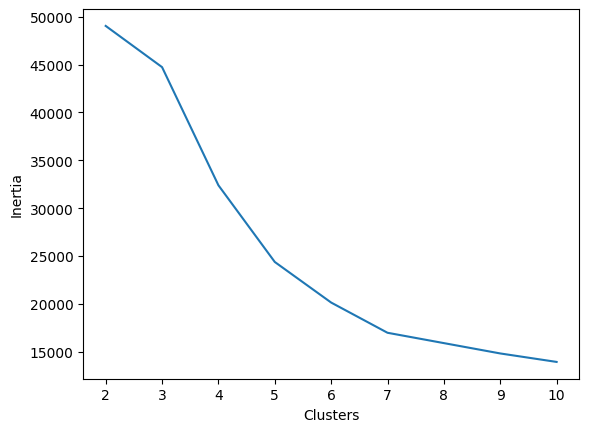

In [ ]:
##############################################################################
# Select Variables
# We keep top 5 numerical values from Random forest selection 'usd_pledged','backers_count'
X = kickstarter_df[['state','backers_count','usd_pledged','goal_usd','name_len_clean']]

##############################################################################
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

from sklearn.cluster import KMeans

#Elbow Method to determine number of optimal clusters
withinss = []
for i in range (2,10):
    kmeans = KMeans(n_clusters=i)
    model = kmeans.fit(X_std)
    withinss.append(model.inertia_)

from matplotlib import pyplot as plt
plt.plot([2,3,4,5,6,7,9,10],withinss)
plt.xlabel("Clusters")
plt.ylabel("Inertia")


## KMeans with 5 Custers

In [ ]:
## We choose n_cluster = 5

#KMean
kmeans = KMeans(n_clusters = 5, random_state = 5)
model = kmeans.fit(X_std)
labels = model.predict(X_std)

#Silhouette
from sklearn.metrics import silhouette_score
silhouette_score(X_std,labels)
from sklearn.metrics import silhouette_samples
silhouette = silhouette_samples(X_std,labels)

#Label and silhouette score for each obeservation
score_silhouette = pd.DataFrame({'label':labels,'silhouette':silhouette})

silhouette1 = np.average(score_silhouette[score_silhouette['label'] == 0].silhouette)
silhouette2 = np.average(score_silhouette[score_silhouette['label'] == 1].silhouette)
silhouette3 = np.average(score_silhouette[score_silhouette['label'] == 2].silhouette)
silhouette4 = np.average(score_silhouette[score_silhouette['label'] == 3].silhouette)
silhouette5 = np.average(score_silhouette[score_silhouette['label'] == 4].silhouette)

silhouette_array = np.array([silhouette1,silhouette2,silhouette3,silhouette4,silhouette5])

column_values = ['Average Silhouette score']
index_values = ["Cluster 1","Cluster 2","Cluster 3","Cluster 4","Cluster 5"]
silhouette = pd.DataFrame(data = silhouette_array, index = index_values, columns = column_values).round(decimals = 3)
print(silhouette)


           Average Silhouette score
Cluster 1                     0.411
Cluster 2                     0.311
Cluster 3                     0.204
Cluster 4                     0.391
Cluster 5                     0.432


In [ ]:
#Centroid of each cluster
cent_clust1 = kmeans.cluster_centers_[0]
cent_clust2 = kmeans.cluster_centers_[1]
cent_clust3 = kmeans.cluster_centers_[2]
cent_clust4 = kmeans.cluster_centers_[3]
cent_clust5 = kmeans.cluster_centers_[4]

cluster_array = np.array([cent_clust1,cent_clust2,cent_clust3,cent_clust4,cent_clust5])

column_values = [X]
index_values = ["Cluster 1","Cluster 2","Cluster 3","Cluster 4","Cluster 5"]
clusters = pd.DataFrame(data = cluster_array, index = index_values, columns= X.columns).round(decimals = 2)
print(clusters)

#Count
kickstarter_df['cluster'] = model.labels_

           state  backers_count  usd_pledged  goal_usd  name_len_clean
Cluster 1  -1.13          -0.47        -0.41      0.08           -0.11
Cluster 2   0.86           0.20         0.17     -0.22            0.98
Cluster 3   0.87           3.61         3.44      0.26            0.28
Cluster 4  -1.13          -0.50        -0.41      7.20           -0.09
Cluster 5   0.88           0.03        -0.01     -0.26           -0.67


In [ ]:
kickstarter_df['cluster'].value_counts()


,count
cluster,
0,5716
4,3895
1,3157
2,553
3,154


# Clusters

In [ ]:
kickstarter_df[kickstarter_df['cluster'] == 0].describe()

,state,backers_count,usd_pledged,name_len_clean,blurb_len_clean,goal_usd,months_diff_bw_create_launch,months_diff_bw_launch_deadline,cluster
count,5716.0,5716.000000,5716.000000,5716.000000,5716.000000,5716.000000,5716.000000,5716.000000,5716.0
mean,0.0,10.729181,885.171463,4.743527,15.419524,15837.412116,1.398962,-1.240856,0.0
std,0.0,20.562870,2403.804603,2.279354,5.599400,22355.321382,3.775568,0.471003,0.0
min,0.0,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,-2.233333,0.0
25%,0.0,2.000000,6.970878,3.000000,12.000000,2297.706388,0.033333,-1.566667,0.0
50%,0.0,4.000000,100.000000,5.000000,17.000000,7000.000000,0.266667,-1.000000,0.0
75%,0.0,11.000000,601.012263,6.250000,20.000000,20000.000000,1.000000,-1.000000,0.0
max,0.0,273.000000,36825.000000,12.000000,28.000000,131770.205424,54.066667,-0.033333,0.0


In [ ]:
kickstarter_df[kickstarter_df['cluster'] == 1].describe()

,state,backers_count,usd_pledged,name_len_clean,blurb_len_clean,goal_usd,months_diff_bw_create_launch,months_diff_bw_launch_deadline,cluster
count,3157.000000,3157.000000,3157.000000,3157.000000,3157.000000,3157.000000,3157.000000,3157.000000,3157.0
mean,0.989547,97.131454,8255.798269,7.219195,15.643966,5875.191716,2.023408,-1.025256,1.0
std,0.101720,86.275512,8445.661089,1.295933,4.931913,7179.114601,4.379578,0.368211,0.0
min,0.000000,0.000000,0.000000,5.000000,1.000000,0.766114,0.000000,-4.033333,1.0
25%,1.000000,32.000000,2003.000000,6.000000,13.000000,992.437627,0.200000,-1.066667,1.0
50%,1.000000,69.000000,5217.000000,7.000000,17.000000,3177.299670,0.600000,-1.000000,1.0
75%,1.000000,138.000000,11685.000000,8.000000,19.000000,8000.000000,1.733333,-0.900000,1.0
max,1.000000,502.000000,50600.000000,14.000000,28.000000,60000.000000,63.600000,-0.100000,1.0


In [ ]:
kickstarter_df[kickstarter_df['cluster'] == 2].describe()

,state,backers_count,usd_pledged,name_len_clean,blurb_len_clean,goal_usd,months_diff_bw_create_launch,months_diff_bw_launch_deadline,cluster
count,553.000000,553.000000,553.000000,553.000000,553.000000,553.000000,553.000000,553.000000,553.0
mean,0.990958,538.399638,49414.948659,5.623870,15.356239,21862.423267,2.208258,-1.064738,2.0
std,0.094742,259.908828,30159.932073,2.041137,4.589059,18315.467724,3.642846,0.281431,0.0
min,0.000000,20.000000,5213.010000,1.000000,1.000000,60.875017,0.000000,-2.033333,2.0
25%,1.000000,375.000000,30090.206572,4.000000,12.000000,8815.155040,0.400000,-1.100000,2.0
50%,1.000000,489.000000,42116.307199,6.000000,16.000000,16117.195650,1.000000,-1.000000,2.0
75%,1.000000,650.000000,59257.759822,7.000000,19.000000,30000.000000,2.466667,-1.000000,2.0
max,1.000000,1612.000000,246395.000000,11.000000,27.000000,100000.000000,28.900000,-0.266667,2.0


In [ ]:
kickstarter_df[kickstarter_df['cluster'] == 3].describe()

,state,backers_count,usd_pledged,name_len_clean,blurb_len_clean,goal_usd,months_diff_bw_create_launch,months_diff_bw_launch_deadline,cluster
count,154.0,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.0
mean,0.0,6.422078,902.974555,4.779221,16.246753,250217.143049,1.362121,-1.345671,3.0
std,0.0,13.754991,3055.833598,2.223601,4.910056,116395.353521,3.320446,0.464576,0.0
min,0.0,0.000000,0.000000,1.000000,3.000000,134430.941700,0.000000,-2.033333,3.0
25%,0.0,1.000000,2.000000,3.000000,13.250000,160720.396205,0.133333,-2.000000,3.0
50%,0.0,3.000000,49.429702,5.000000,17.000000,205781.683750,0.400000,-1.100000,3.0
75%,0.0,6.000000,305.189003,6.000000,20.000000,295279.434295,1.125000,-1.000000,3.0
max,0.0,122.000000,28506.394984,10.000000,26.000000,629149.557350,29.933333,-0.333333,3.0


In [ ]:
kickstarter_df[kickstarter_df['cluster'] == 4].describe()

,state,backers_count,usd_pledged,name_len_clean,blurb_len_clean,goal_usd,months_diff_bw_create_launch,months_diff_bw_launch_deadline,cluster
count,3895.0,3895.000000,3895.000000,3895.000000,3895.000000,3895.000000,3895.000000,3895.000000,3895.0
mean,1.0,74.954044,5978.936674,3.462901,13.832606,4522.600528,1.691613,-1.065400,4.0
std,0.0,68.659793,6531.199739,1.225100,5.530669,5525.821794,4.148655,0.392760,0.0
min,1.0,1.000000,1.000000,1.000000,1.000000,0.760390,0.000000,-2.233333,4.0
25%,1.0,26.000000,1376.823344,3.000000,9.000000,750.000000,0.166667,-1.100000,4.0
50%,1.0,52.000000,3581.000000,4.000000,14.000000,2485.766162,0.500000,-1.000000,4.0
75%,1.0,102.000000,8176.500000,4.000000,18.000000,6000.000000,1.433333,-0.933333,4.0
max,1.0,443.000000,51290.724370,5.000000,28.000000,42000.000000,56.133333,-0.066667,4.0
